## SPY Predictions

### A more compact notebook for analyzing the model's output

### The Notebook's parameters

In [1]:
# Target minutes
# The target minutes we train our model on
T = 60

# Standard deviation level
#STD = .01
# Threshold value for class
thValMin = 0.00
thValMax = 100

# Balance Classes
Balance = False

# Standardize data
Standardize = False

# Smooth data (savgol/rolling/none)
Smooth = "None"

# Window size for smoothing
Window_size = 131

# Polynomial Order (For Savgol filter)
Poly_order = 9

# Class weights
Class_Weights = "balanced"

# Time Boosting
Time_Boosting = False

# Features to use
Kfeatures = 5

# Data file name
Data_path = "KO_1M.csv"
dailyBars = False

###########################################################################JP Nieto
test_size = 0.3  
#
# Rows iteration
nrows = 200100                      # total rows from the file to be loaded
Rows_Skip = 0                   # Rows to skip ( will omit this number of rows from any analysis)
#
# Remaining (nrows - Rows_skip)  will be analyzed with moving window
# 
# nRowsW has to be less than the remaining rows...if not will decreased accordingly
nRowsW = 50000                     # Window Size ---moving window
# 
nWindowIteration = 1             # n of moving considered....minimum 1
nRowsStep = 1                  # step from one window to the next .....minimun 1
#
# if nWindowIteration goes above number of rows considered will not be executed
remainingRows = nrows-Rows_Skip
if nRowsW > remainingRows:
    nRowsW = remainingRows

maxCount = 0
for i in range(nWindowIteration):
    if nRowsW + nRowsStep * (i) < remainingRows:
        maxCount = i
nWindowIteration = maxCount+1
print ('Total Rows:',nrows)
print ('skipped Rows:',Rows_Skip )
print ('Remaining Rows:',remainingRows)
print ('Window size:',nRowsW)
print ('Rows steps:',nRowsStep)
print ('iterations:', nWindowIteration)
###########################################################################JP Nieto

################ P&L settings############### WARNING DOES NOT WORK WITH BALANCED SETS  ###JP Nieto
accSize       = 100000
percentTrade  = 100
percentCost   = 0.00  # percent of trading amount for total cost (round trip)

NbarsExit     = 0

exitEndSession     = True                     # Exit trades at 15:59   True/False
onlyRegularHours   = True                     # Only open trades after 9:30   True/False

entryLimit         = False                    # limit order for entry...exit is market order
entryLimitCents    = 0.01                     # cents of limit above / below open
entryLimitType     = 'P'                      # 'P' = passive(current one) or 'A' agressive 

signalDelayNbars   = 0                       # 0 == no delay

exitFixWindow      = True           
exitFixWindowNbars = 60

if exitFixWindow:
    NbarsExit = 0
#############################################################################

Total Rows: 200100
skipped Rows: 0
Remaining Rows: 200100
Window size: 50000
Rows steps: 1
iterations: 1


In [2]:
def balance(X, Y):
    if(not isinstance(Y, pd.Series)):
        Y = pd.Series(Y)
    Y.reset_index(inplace=True, drop=True)
    if(not isinstance(X, pd.DataFrame)):
        X = pd.DataFrame(X)
    histogram = Y.value_counts()
    minimum = np.min(histogram)
    classes = histogram.index.values
    for a_class, count in zip(classes, histogram):
        if (count - minimum > 0):
            to_remove = count - minimum
            drop_indices = np.random.choice(X[Y == a_class].index.values, to_remove, replace=False)
            X.drop(drop_indices, inplace=True)
            Y.drop(drop_indices, inplace=True)
    X.reset_index(inplace=True, drop=True)
    Y.reset_index(inplace=True, drop=True)
    return X, Y

In [3]:
'''
def discretize(x, std):
    if(x < -STD * std):
        return -1
    elif(x > STD * std):
        return 1
    else:
        return 0
'''

'\ndef discretize(x, std):\n    if(x < -STD * std):\n        return -1\n    elif(x > STD * std):\n        return 1\n    else:\n        return 0\n'

In [4]:
def discretize(x, thVal):
    thValMx = thVal[1]
    thValMn = thVal[0]
    if x < - thValMx:
        return -2
    elif  x < -thValMn :
        return -1
    elif  x <= thValMn :
        return 0
    elif  x <= thValMx :
        return 1
    else:
        return 2

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from datetime import datetime

# Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
#from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor


from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.linear_model import ARDRegression, BayesianRidge, LinearRegression, LogisticRegression, Lasso, ElasticNet, Lars, LassoLars, Ridge, SGDClassifier, Perceptron, SGDRegressor, PassiveAggressiveClassifier, PassiveAggressiveRegressor, HuberRegressor, TheilSenRegressor, RANSACRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import NuSVC, SVC, LinearSVC
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, LSHForest
from sklearn.neural_network import MLPClassifier, MLPRegressor, BernoulliRBM
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor, ExtraTreesClassifier, ExtraTreesRegressor, GradientBoostingClassifier, GradientBoostingRegressor, RandomTreesEmbedding, BaggingClassifier, BaggingRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
#from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score

%matplotlib inline


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load data and compare classifiers

In [6]:
names = [
        #"Nearest Neighbors",
        #"Linear SVM",
        "Logistic Regression",
        #"RBF SVM",
        #"Decision Tree",
        #"Random Forest",
        #"Neural Net",
        #"AdaBoost",
        #"Naive Bayes",
        #"Tree Decision Regressor"
        #"XGBoost"
        #"ExtraTreesClassifier",
        #"GradientBoostingClassifier", 
        #"ARDRegression"
        #"BayesianRidge",
        #"SGDClassifier"
        #"Voting_1",   
        #"Voting_2",  #always use Voting then add more charaters or numbers .....Always Voting names after all the others classifiers
        #"Majority_80"
]
print (names)
classifiers = [
        #KNeighborsClassifier(7),
        #SVC(kernel="linear", C=0.025, class_weight=Class_Weights, probability=True),
        LogisticRegression(class_weight=Class_Weights),
        #SVC(class_weight=Class_Weights, C=100, probability=True),
        #DecisionTreeClassifier(max_depth=9, class_weight=Class_Weights),
        #RandomForestClassifier(max_depth=9, n_estimators=40, n_jobs=-1, class_weight=Class_Weights, min_samples_leaf=100),
        #MLPClassifier(),
        #AdaBoostClassifier(n_estimators=100),
        #GaussianNB(),
        #DecisionTreeRegressor(random_state=0),
        #XGBClassifier(n_estimators=20, max_depth=9),
        #ExtraTreesClassifier(n_estimators=25, max_depth=5),
        #GradientBoostingClassifier(n_estimators=25,loss='deviance'), 
        #ARDRegression(n_iter=10)
        #BayesianRidge(),
        #SGDClassifier(loss='log')   
    
        # All models below only consider models above that line
        #['soft',1,1,1],     # for each 'voting' add a list with weights  with the same length as the number of classifiers actives ..in this case 3
        #['hard',1,1,1],
        #[80]  # 80% of votes to get -1 or +1 class otherwise 0
]
print (classifiers)
#Prob_available = [1,1,1,1,1,1]
#
modelsRun       = []
predictions     = []
predictionsTest = []
probabilities   = []
accuracyTrain   = []
accuracyTest    = []
gProfits        = []
gLosses         = []
printTrades     = []
position        = []
entryPrice      = []
PL              = []
accountVal      = []
trades          = []
idxTrades       = []
tradesProbs     = []
pFactors        = []
predicts        = []
barsIt          = []
dateTimeIt      = []
changesIt       = []

#
for it in range(nWindowIteration):
    stRow = Rows_Skip + nRowsStep * it
    endRow = Rows_Skip + nRowsStep * it + nRowsW
    print ('----======================================---')
    print ('Iteration:',it+1)
    print ('Starting row:',stRow)
    print ('End row:',endRow)
    data = pd.read_csv(Data_path, nrows=nrows)                                      ##############################JP Nieto
    data = data[stRow:endRow]                                                       ##############################JP Nieto
    print('Window Data Length:'+str(len(data)))                                     ##############################JP Nieto

    bars = data.iloc[:,2:6].copy(deep=True)                                         ##############################JP Nieto
    dateTime = data.iloc[:,:2].copy(deep=True)                                      ##############################JP Nieto

    if(Smooth == "savgol"):
        data["Open"] = savgol_filter(data["Open"], Window_size, Poly_order)
        data["Close"] = savgol_filter(data["Close"], Window_size, Poly_order)
    elif(Smooth == "rolling"):
        data["Open"] = data["Open"].rolling(Window_size, center=True).mean().interpolate(limit=Window_size, limit_direction="both")
        data["Close"] = data["Close"].rolling(Window_size, center=True).mean().interpolate(limit=Window_size, limit_direction="both")
    #
    ##############################JP Nieto
    #Change = data["Close"] - data["Open"]
    #ChangeR = data["Close"] - data["Open"]
    Change = data["Close"].copy(deep=True) #- data["Open"]
    ChangeR = data["Close"].copy(deep=True) # - data["Open"]
    #
    for rw in range(len(Change)):
        if rw < len(Change)-T-1:
            Change.values[-rw-1] = Change.values[-rw-1] - Change.values[-rw-1-T]
            ChangeR.values[-rw-1] = ChangeR.values[-rw-1] - ChangeR.values[-rw-1-T]
        else:
            Change.values[-rw-1] = 0
            ChangeR.values[-rw-1] = 0
    ##############################JP Nieto
    #
    #
    std = np.std(Change)
    data.drop(data.index.values[-T:], inplace=True)
    ChangeR.drop(ChangeR.index.values[-T:], inplace=True)                           ##############################JP Nieto
    Change.drop(Change.index.values[:T], inplace=True)
    bars.drop(bars.index.values[-T:], inplace=True)                                 ##############################JP Nieto
    dateTime.drop(dateTime.index.values[-T:], inplace=True)                         ##############################JP Nieto

    data.reset_index(inplace=True, drop=True)
    ChangeR.reset_index(inplace=True, drop=True)                                    ##############################JP Nieto
    Change.reset_index(inplace=True, drop=True)
    bars.reset_index(inplace=True, drop=True)                                       ##############################JP Nieto
    dateTime.reset_index(inplace=True, drop=True)                                   ##############################JP Nieto
        
    Change = Change.apply(discretize, args=([thValMin,thValMax], ))                 ##############################JP Nieto
   
    if(Standardize):
        X = StandardScaler().fit_transform(data[data.columns.difference(["Time", "Date"])].as_matrix())
    else:
        X = data[data.columns.difference(["Time", "Date"])].as_matrix()
    Y = Change
       
    if(Balance):
        X, Y = balance(X, Y)

    if(not isinstance(Y, pd.Series)):
        Y = pd.Series(Y)  
        
    test_startRow = len(X)-int(len(X)*test_size)                                    ##############################JP Nieto
    
    #changeTrain = Change[:test_startRow]
    
    #qT33 = np.percentile(changeTrain.values,33)
    #qT66 = np.percentile(changeTrain.values,66)
    #for zv in range(len(Change)):
    #    if Change.ix[zv] >= thVal:
    #        Change.ix[zv]= 1
    #    elif Change.ix[zv] < -thVal:
    #        Change.ix[zv]= 0
    #else:
    #       Change.ix[zv]= 0
        
    #test_startRow = len(X)-int(len(X)*test_size)                                    ##############################JP Nieto

    #X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

    X_train = X[:test_startRow]                                                     ##############################JP Nieto 
    X_test = X[test_startRow:]                                                      ##############################JP Nieto
    Y_train = Y[:test_startRow]                                                     ##############################JP Nieto
    Y_test = Y[test_startRow:]                                                      ##############################JP Nieto


    X_test = pd.DataFrame(X_test)
    X_test_time_date = data.loc[X_test.index.values][["Time", "Date"]]
    X_test_change = Change.loc[X_test.index.values]

    selector = SelectKBest(score_func=f_regression, k=Kfeatures)
    X_train = selector.fit_transform(X_train, Y_train)
    X_test = selector.transform(X_test)


    #if(Time_Boosting):
    #   sample_weights = range(1, len(X_train) + 1)
    #  sample_weights = np.asfarray(sample_weights) / (0.1 * np.max(sample_weights))
    #else:
    #   sample_weights = np.ones((len(X_train)))
    ###################################################################JP
    if len(barsIt) < (it+1):
        barsIt.append(bars)
        dateTimeIt.append(dateTime)
        changesIt.append(ChangeR)
    
    estima = []
    ###################################################################
    for idx, cname, clf1 in zip(range(len(names)), names, classifiers):
        modelsRun.append([idx,cname,stRow,endRow])
        if cname[:8] == 'Majority':
            predictX = [0] * len(X) 
            for posX in range(len(X)):
                ctt = 0 
                ctp = 0
                ctn = 0
                for mr in range(len(modelsRun)):
                    cnm = modelsRun[mr][1]
                    if not (cnm[:6] =='Voting' or cnm[:8] =='Majority'):
                        ctt += 1
                        if predictions[mr][posX] == 1:
                            ctp += 1
                        if predictions[mr][posX] == -1:
                            ctn += 1
                if ctp / ctt * 100 > 80:
                    predictX[posX] = 1
                if ctn / ctt * 100 > 80:
                    predictX[posX] = -1    
            predictions.append(predictX)
            pred_X_train = predictX[:test_startRow]  
            pred_X_test = predictX[test_startRow:] 
            #
            print("####### " + cname + " ########")  
        else:
            if cname[:6] =='Voting':
                clf = VotingClassifier(estimators= estima, voting=clf1[0], weights = clf1[1:])
                try:
                    clf.fit(X_train, Y_train) #, sample_weights)
                except TypeError:
                    clf.fit(X_train, Y_train)
            else:
                clf = clf1
                try:
                    clf.fit(X_train, Y_train) #, sample_weights)
                except TypeError:
                    clf.fit(X_train, Y_train)
                estima.append((cname,clf))
            predictionsTest.append(clf.predict(X_test))
            try:
                probabilities.append(np.amax(clf.predict_proba(X_test), axis=1))
            except:
                probabilities.append(0.5 * np.ones(len(X_test)))           
            print("####### " + cname + " ########")
            #print(confusion_matrix(Y_test, predictions[idx]))
            #print(classification_report(Y_test, predictions[idx]))
            #print(pd.crosstab(Y_test, predictions[idx], rownames=['True'], colnames=['Predicted']).apply(lambda r: 100.0 * r/r.sum()))
            #
            #print ('Accuracy train set:',accuracy_score(Y_train,clf.predict(X_train)))
            #print ('Accuracy test set:',accuracy_score(Y_test,clf.predict(X_test)))
            ### P&L #########################################################JP Nieto
            #
            predictX = clf.predict(selector.transform(X))
            predictions.append(predictX)
            #
            pred_X_train = clf.predict(X_train)
            pred_X_test = clf.predict(X_test)
            if cname == "ARDRegression" or "BayesianRidge":
                for ro in range(len(predictX)):
                    if predictX[ro] > 0:
                        predictX[ro] = 1
                    elif predictX[ro] < 0:
                        predictX[ro] = -1
                #
                for ro in range(len(pred_X_train)):
                    if pred_X_train[ro] > 0:
                        pred_X_train[ro] = 1
                    elif pred_X_train[ro] < 0:
                        pred_X_train[ro] = -1
                #
                for ro in range(len(pred_X_test)):
                    if pred_X_test[ro] > 0:
                        pred_X_test[ro] = 1
                    elif pred_X_test[ro] < 0:
                        pred_X_test[ro] = -1
        #        
        accuracyTrain.append(accuracy_score(Y_train,pred_X_train))
        accuracyTest.append(accuracy_score(Y_test,pred_X_test))
        #
        try:
            probX = np.amax(clf.predict_proba(selector.transform(X)), axis=1)
        except:
            probX = 0.5 * np.ones(len(X))  
        #
        positionC   = [] # lists for cname  
        entryPriceC = []
        PLC         = []
        accountValC = []
        tradesC     = [] # this list only has data for an ending trade ...the rest for each bar
        idxTradesC  = []
        predictsC   = []
        tradesProbsC= []
        barCount = 0
        idxEntryBar = 0
        eProb = 0
        for i in range(len(X)):
            if i <= test_startRow + signalDelayNbars:
                if i >= test_startRow + signalDelayNbars - 1:
                    positionC.append(0)
                    entryPriceC.append(0.0)
                    PLC.append(0.0)
                    accountValC.append(accSize)
            else:
                pred = predictX[i-1-signalDelayNbars]      # Use previous bar signal + delay if signalDelayNbars > 0
                predictsC.append([i-1-signalDelayNbars,pred])
                lastProb = probX[i-1-signalDelayNbars] 
                if not dailyBars:
                    if dateTime['Date'][i-1] < dateTime['Date'][i]:            # limit trades on new day based on previous day last bar
                        pred = 0
                    if onlyRegularHours and dateTime['Time'][i-1] < '09:30':   # filter signal if onlyRegularHours is True
                        pred = 0
                #
                check = True
                currentBarTrade = False
                if (not dailyBars) and exitEndSession and ( i == (len(X)-1) or ( i < (len(X)-1) and (dateTime['Date'][i] < dateTime['Date'][i+1] or dateTime['Time'][i] > '15:59'))):
                    check = False
                    if positionC[-1] < 0:
                        tradesC.append((bars['Open'].values[i]-entryPriceC[-1])*positionC[-1] + bars['Open'].values[i]*positionC[-1] * percentCost/100 )
                        idxTradesC.append(idxEntryBar) #-test_startRow)
                        tradesProbsC.append(eProb)
                        accountValC.append(accountValC[-1]+tradesC[-1])
                        positionC.append(0)
                        entryPriceC.append(0)
                        PLC.append(0)
                        printTrades.append([it,cname,dateTime['Date'].values[i-1-signalDelayNbars]+' '+dateTime['Time'].values[i-1-signalDelayNbars],'ExitEndSession',dateTime['Date'].values[i]+' '+dateTime['Time'].values[i],round(bars['Open'].values[i],5),round(entryPriceC[-2],5),positionC[-2],tradesC[-1]])
                        #printNTrades -= 1
                    elif positionC[-1] > 0:
                        tradesC.append((bars['Open'].values[i]-entryPriceC[-1])*positionC[-1] - bars['Open'].values[i]*positionC[-1] * percentCost/100 )
                        idxTradesC.append(idxEntryBar)#-test_startRow)
                        tradesProbsC.append(eProb)
                        accountValC.append(accountValC[-1]+tradesC[-1])
                        positionC.append(0)
                        entryPriceC.append(0)
                        PLC.append(0)
                        printTrades.append([it,cname,dateTime['Date'].values[i-1-signalDelayNbars]+' '+dateTime['Time'].values[i-1-signalDelayNbars],'ExitEndSession',dateTime['Date'].values[i]+' '+dateTime['Time'].values[i],round(bars['Open'].values[i],5),round(entryPriceC[-2],5),positionC[-2],tradesC[-1]])
                        #printNTrades -= 1
                    else:
                        positionC.append(0)
                        entryPriceC.append(0)
                        accountValC.append(accountValC[-1])
                        PLC.append(0)
                if check and exitFixWindow:
                    if not positionC[-1] == 0:
                        barCount += 1
                        if  barCount > exitFixWindowNbars:
                            if positionC[-1] < 0:
                                tradesC.append((bars['Open'].values[i]-entryPriceC[-1])*positionC[-1] + bars['Open'].values[i]*positionC[-1] * percentCost/100 )
                                idxTradesC.append(idxEntryBar)#-test_startRow)
                                tradesProbsC.append(eProb)
                                accountValC.append(accountValC[-1]+tradesC[-1])
                                positionC.append(0)
                                entryPriceC.append(0)
                                PLC.append(0)
                                printTrades.append([it,cname,0,'ExitShortWindowCntB',dateTime['Date'].values[i]+' '+dateTime['Time'].values[i],round(bars['Open'].values[i],5),round(entryPriceC[-2],5),positionC[-2],tradesC[-1]])
                                currentBarTrade = True
                            if positionC[-1] > 0:
                                tradesC.append((bars['Open'].values[i]-entryPriceC[-1])*positionC[-1] - bars['Open'].values[i]*positionC[-1] * percentCost/100 )
                                idxTradesC.append(idxEntryBar)#-test_startRow)
                                tradesProbsC.append(eProb)
                                accountValC.append(accountValC[-1]+tradesC[-1])
                                positionC.append(0)
                                entryPriceC.append(0)
                                PLC.append(0)
                                printTrades.append([it,cname,0,'ExitLongWindowCntB',dateTime['Date'].values[i]+' '+dateTime['Time'].values[i],round(bars['Open'].values[i],5),round(entryPriceC[-2],5),positionC[-2],tradesC[-1]])
                                currentBarTrade = True
                if check and exitFixWindow and not currentBarTrade:
                    if not positionC[-1] == 0:
                        positionC.append(positionC[-1])
                        entryPriceC.append(entryPriceC[-1])
                        accountValC.append(accountValC[-1])
                        PLC.append((bars['Close'].values[i]-entryPriceC[-1])*positionC[-1])
                        check = False
                    elif pred == 0:
                        positionC.append(0)
                        entryPriceC.append(0)
                        accountValC.append(accountValC[-1])
                        PLC.append(0)
                        check = False
                if check and not exitFixWindow and pred == 0:
                    if not positionC[-1] == 0:
                        barCount += 1
                        if barCount > NbarsExit:
                            if positionC[-1] < 0:
                                tradesC.append((bars['Open'].values[i]-entryPriceC[-1])*positionC[-1] + bars['Open'].values[i]*positionC[-1] * percentCost/100 )
                                idxTradesC.append(idxEntryBar)#-test_startRow)
                                tradesProbsC.append(eProb)
                                accountValC.append(accountValC[-1]+tradesC[-1])
                                positionC.append(0)
                                entryPriceC.append(0)
                                PLC.append(0)
                                printTrades.append([it,cname,dateTime['Date'].values[i-1-signalDelayNbars]+' '+dateTime['Time'].values[i-1-signalDelayNbars],'ExitShortCntB',dateTime['Date'].values[i]+' '+dateTime['Time'].values[i],round(bars['Open'].values[i],5),round(entryPriceC[-2],5),positionC[-2],tradesC[-1]])
                                currentBarTrade = True
                            if positionC[-1] > 0:
                                tradesC.append((bars['Open'].values[i]-entryPriceC[-1])*positionC[-1] - bars['Open'].values[i]*positionC[-1] * percentCost/100 )
                                idxTradesC.append(idxEntryBar)#-test_startRow)
                                tradesProbsC.append(eProb)
                                accountValC.append(accountValC[-1]+tradesC[-1])
                                positionC.append(0)
                                entryPriceC.append(0)
                                PLC.append(0)
                                printTrades.append([it,cname,dateTime['Date'].values[i-1-signalDelayNbars]+' '+dateTime['Time'].values[i-1-signalDelayNbars],'ExitLongCntBar',dateTime['Date'].values[i]+' '+dateTime['Time'].values[i],round(bars['Open'].values[i],5),round(entryPriceC[-2],5),positionC[-2],tradesC[-1]])
                                currentBarTrade = True
                        else:
                            positionC.append(positionC[-1])
                            entryPriceC.append(entryPriceC[-1])
                            accountValC.append(accountValC[-1])
                            PLC.append((bars['Close'].values[i]-entryPriceC[-1])*positionC[-1])
                            check = False
                    else:
                        positionC.append(0)
                        entryPriceC.append(0)
                        accountValC.append(accountValC[-1])
                        PLC.append(0) 
                        check = False
                if check and pred == 1:
                    if positionC[-1] > 0:
                        positionC.append(positionC[-1])
                        entryPriceC.append(entryPriceC[-1])
                        accountValC.append(accountValC[-1]) 
                        PLC.append((bars['Close'].values[i]-entryPriceC[-1])*positionC[-1])
                    if  positionC[-1] <= 0:
                        # This is at open when the signal of previous bar is available. Not big difference for 1 min bars if we use close.
                        closingTrade = False
                        if positionC[-1] < 0:
                            tradesC.append((bars['Open'].values[i]-entryPriceC[-1])*positionC[-1] + bars['Open'].values[i]*positionC[-1] * percentCost/100 )
                            idxTradesC.append(idxEntryBar)#-test_startRow)
                            tradesProbsC.append(eProb)
                            accountValC.append(accountValC[-1]+tradesC[-1])
                            closingTrade = True
                        else:
                            if not currentBarTrade:
                                accountValC.append(accountValC[-1])
                        # new position
                        if not entryLimit or (entryLimitType == 'P' and bars['Open'].values[i] - entryLimitCents >= bars['Low'].values[i]) or (entryLimitType == 'A' and bars['Open'].values[i] + entryLimitCents <= bars['High'].values[i]):
                            nShares = int ((accountValC[-1] * percentTrade / 100 ) / bars['Open'].values[i])
                            if currentBarTrade == True:
                                del positionC[-1]
                                del entryPriceC[-1]
                                del PLC[-1]
                            positionC.append(nShares)
                            idxEntryBar= i
                            eProb = lastProb
                            if entryLimit and entryLimitType == 'P':
                                entryPriceC.append(bars['Open'].values[i] - entryLimitCents)
                            elif entryLimit and entryLimitType == 'A':
                                 entryPriceC.append(bars['Open'].values[i] + entryLimitCents)
                            else:
                                entryPriceC.append(bars['Open'].values[i])
                            PLC.append((bars['Close'].values[i]-entryPriceC[-1]) * positionC[-1]) # pnl open to close on current bar
                            
                            if closingTrade:
                                printTrades.append([it,cname,dateTime['Date'].values[i-1-signalDelayNbars]+' '+dateTime['Time'].values[i-1-signalDelayNbars],'LongSignal1',dateTime['Date'].values[i]+' '+dateTime['Time'].values[i],round(bars['Open'].values[i],5),round(entryPriceC[-2],5),positionC[-2],tradesC[-1]])
                            else:
                                printTrades.append([it,cname,dateTime['Date'].values[i-1-signalDelayNbars]+' '+dateTime['Time'].values[i-1-signalDelayNbars],'LongSignal2',dateTime['Date'].values[i]+' '+dateTime['Time'].values[i],0,round(entryPriceC[-2],5),positionC[-2],0])
                        else:
                            positionC.append(0)
                            entryPriceC.append(0)
                            PLC.append(0) # pnl open to close on current bar
                            if closingTrade:
                                printTrades.append([it,cname,dateTime['Date'].values[i-1-signalDelayNbars]+' '+dateTime['Time'].values[i-1-signalDelayNbars],'LongSignalNotFilled',dateTime['Date'].values[i]+' '+dateTime['Time'].values[i],0,round(entryPriceC[-2],5),positionC[-2],tradesC[-1]])
                            else:
                                printTrades.append([it,cname,dateTime['Date'].values[i-1-signalDelayNbars]+' '+dateTime['Time'].values[i-1-signalDelayNbars],'LongSignalNotFilled',dateTime['Date'].values[i]+' '+dateTime['Time'].values[i],0,round(entryPriceC[-2],5),positionC[-2],0])
                    barCount = 1
                if check and pred == -1:
                    if positionC[-1] < 0: 
                        positionC.append(positionC[-1])
                        entryPriceC.append(entryPriceC[-1])
                        accountValC.append(accountValC[-1]) 
                        PLC.append((bars['Close'].values[i]-entryPriceC[-1])*positionC[-1])
                    if  positionC[-1] >= 0:
                        # This is at open when the signal of previous bar is available. Not big difference for 1 min bars if we use close.
                        closingTrade = False
                        if positionC[-1] > 0:
                            tradesC.append((bars['Open'].values[i]-entryPriceC[-1])*positionC[-1] - bars['Open'].values[i] * positionC[-1] * percentCost/100)
                            idxTradesC.append(idxEntryBar)#-test_startRow)
                            tradesProbsC.append(eProb)
                            accountValC.append(accountValC[-1]+tradesC[-1])
                            closingTrade = True
                        else:
                            if not currentBarTrade:
                                accountValC.append(accountValC[-1])
                        # new position
                        if not entryLimit or (entryLimitType == 'P' and bars['Open'].values[i]+entryLimitCents <= bars['High'].values[i]) or (entryLimitType == 'A' and bars['Open'].values[i]-entryLimitCents >= bars['Low'].values[i]):
                            nShares = int ((accountValC[-1] * percentTrade / 100 ) / bars['Open'].values[i])
                            if currentBarTrade == True:
                                del positionC[-1]
                                del entryPriceC[-1]
                                del PLC[-1]
                            positionC.append(-nShares)
                            idxEntryBar= i
                            eProb = lastProb 
                            if entryLimit and entryLimitType == 'P':   # deactivated for shorts
                                entryPriceC.append(bars['Open'].values[i] + entryLimitCents)
                            elif entryLimit and entryLimitType == 'A':     # deactivated for shorts
                                entryPriceC.append(bars['Open'].values[i] - entryLimitCents)
                            else:
                                entryPriceC.append(bars['Open'].values[i])
                            PLC.append((bars['Close'].values[i]-entryPriceC[-1]) * positionC[-1]) # pnl open to close on current bar
                            if closingTrade:
                                printTrades.append([it,cname,dateTime['Date'].values[i-1-signalDelayNbars]+' '+dateTime['Time'].values[i-1-signalDelayNbars],'ShortSignal1',dateTime['Date'].values[i]+' '+dateTime['Time'].values[i],round(bars['Open'].values[i],5),round(entryPriceC[-2],5),positionC[-2],tradesC[-1]])
                            else:
                                printTrades.append([it,cname,dateTime['Date'].values[i-1-signalDelayNbars]+' '+dateTime['Time'].values[i-1-signalDelayNbars],'ShortSignal2',dateTime['Date'].values[i]+' '+dateTime['Time'].values[i],round(bars['Open'].values[i],5),round(entryPriceC[-2],5),positionC[-2],0])
                        else:
                            positionC.append(0)
                            entryPriceC.append(0)
                            PLC.append(0) # pnl open to close on current bar
                            if closingTrade:
                                printTrades.append([it,cname,dateTime['Date'].values[i-1-signalDelayNbars]+' '+dateTime['Time'].values[i-1-signalDelayNbars],'ShortSignalNotFilled',dateTime['Date'].values[i]+' '+dateTime['Time'].values[i],0,round(entryPriceC[-2],5),positionC[-2],tradesC[-1]])
                            else:
                                printTrades.append([it,cname,dateTime['Date'].values[i-1-signalDelayNbars]+' '+dateTime['Time'].values[i-1-signalDelayNbars],'shortSignalNotFilled',dateTime['Date'].values[i]+' '+dateTime['Time'].values[i],0,round(entryPriceC[-2],5),positionC[-2],0])
                        #printNTrades -= 1
                    barCount = 1
        #print ('Account End: ', accountValC[-1])
        #print ('Number of trades:', len(tradesC))
        grossProfit = 0.0
        grossLoss = 0.0
        for m in range(len(tradesC)):
            if tradesC[m] > 0:
                grossProfit += tradesC[m]
            if tradesC[m] < 0:
                grossLoss += -tradesC[m]
        gProfits.append(grossProfit)
        gLosses.append(grossLoss)
        #print ('Gross Profit:', grossProfit)
        #print ('Gross Loss:', grossLoss)
        if len(tradesC) > 0:
            if grossLoss > 0:
                #print ('Profit Factor: ', grossProfit/grossLoss)
                pFactors.append(grossProfit/grossLoss)
            else:
                #print ('Profit Factor: Infinite')
                pFactors.append('Infinite')
        else:
            #print ('No trades')
            pFactors.append('No trades')

        ### store information for each model ####JP Nieto
        position.append(positionC)  
        entryPrice.append(entryPriceC)
        PL.append(PLC)
        accountVal.append(accountValC) 
        trades.append(tradesC)
        idxTrades.append(idxTradesC)
        tradesProbs.append(tradesProbsC)
        predicts.append(predictsC)

['Logistic Regression']
[LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)]
----======================================---
Iteration: 1
Starting row: 0
End row: 50000
Window Data Length:50000
####### Logistic Regression ########


In [7]:
printModelsRslt = True
#
if printModelsRslt:
    for i in range(len(names)):
        print('--------===========--------')
        for j in range(len(modelsRun)):
            if names[i] == modelsRun[j][1]:
                print (modelsRun[j][1:])
                print ('Accuracy Train:',accuracyTrain[j])
                print ('Accuracy Test0:',accuracyTest[j])
                print ('Account End: ', accountVal[j][-1])
                pPos = 0
                pNeg = 0
                for m in range(len(predicts[j])):
                    if predicts[j][m][1] == 1:
                        pPos += 1
                    if predicts[j][m][1] == -1:
                        pNeg += 1
                print ('Predictions == 1:', pPos)
                print ('Predictions ==-1', pNeg)
                print ('Number of trades:', len(trades[j]))
                tPos = 0
                tNeg = 0
                for m in range(len(trades[j])):
                    if trades[j][m] > 0:
                        tPos += 1
                    if trades[j][m] < 0:
                        tNeg += 1
                print ('Positive trades:', tPos)
                print ('Negative trades', tNeg)
                print ('Gross Profit:', gProfits[j])
                print ('Gross Loss:', gLosses[j])
                print ('Profit Factor:', pFactors[j])
                print ('....')

--------===========--------
['Logistic Regression', 0, 50000]
Accuracy Train: 0.56256078723
Accuracy Test0: 0.522293418769
Account End:  98759.23
Predictions == 1: 8037
Predictions ==-1 6944
Number of trades: 220
Positive trades: 104
Negative trades 101
Gross Profit: 28028.79
Gross Loss: 29269.56
Profit Factor: 0.957608860536
....


In [8]:
nIteration = 1 # window iteration   --- start with 1
nModelm = 0   # number of the previous models on cname
nTrades = 500  # number of trades to print 

nModel = ((nIteration-1) * len(names)) + nModelm

stTrade = 0
ext = False
while not ext:
    if printTrades[stTrade][0] == (nIteration-1) and printTrades[stTrade][1] == names[nModelm]:
        ext = True
    else:
        stTrade += 1
print ('Iteration:',nIteration)
print ('Model:',printTrades[stTrade][1])

cTrades = 0
printed = []
for i in range(len(predicts[nModel])):
    if cTrades < nTrades:
        ix = predicts[nModel][i][0]
        dt = dateTimeIt[nIteration-1]
        for j in range(len(printTrades)):
            if (dt['Date'].values[ix]+' '+dt['Time'].values[ix] == printTrades[j][4] or dt['Date'].values[ix]+' '+dt['Time'].values[ix] == printTrades[j][4]) and printTrades[j][1]== names[nModel]:
                pIt = 1
                for m in range(len(printed)):
                    if printed[m] == j:
                        pIt = 0
                if pIt == 1:
                    print (printTrades[j])
                    printed.append(j)
                    cTrades += 1
        print (dt['Date'].values[ix]+' '+dt['Time'].values[ix],'- Prediction:', predicts[nModel][i][1])

# 
# Interpretation
# ['2010-01-05 10:02', 'ShortSignal', '2010-01-05 10:03', 113.16, 112.98, 177, 29.857067999998691]
# firts number is iteration number
# at close of bar 2010-01-05 10:02 it gets a shortsignal
# enter at open of bar 2010-01-05 10:03 for a short with price 113.16
# at the same time close previous position that has an entry price of 112.98
# with quantity of 177 shares
# P&L of the trade closed is 29.857067999998691


Iteration: 1
Model: Logistic Regression
2010-04-21 09:51 - Prediction: 1
[0, 'Logistic Regression', '2010-04-21 09:51', 'LongSignal2', '2010-04-21 09:52', 0, 0.0, 0, 0]
2010-04-21 09:52 - Prediction: 1
2010-04-21 09:53 - Prediction: -1
2010-04-21 09:54 - Prediction: -1
2010-04-21 09:55 - Prediction: -1
2010-04-21 09:56 - Prediction: -1
2010-04-21 09:57 - Prediction: 1
2010-04-21 09:58 - Prediction: 1
2010-04-21 09:59 - Prediction: 1
2010-04-21 10:00 - Prediction: 1
2010-04-21 10:01 - Prediction: 1
2010-04-21 10:02 - Prediction: 1
2010-04-21 10:03 - Prediction: 1
2010-04-21 10:04 - Prediction: 1
2010-04-21 10:05 - Prediction: 1
2010-04-21 10:06 - Prediction: -1
2010-04-21 10:07 - Prediction: -1
2010-04-21 10:08 - Prediction: -1
2010-04-21 10:09 - Prediction: -1
2010-04-21 10:10 - Prediction: -1
2010-04-21 10:11 - Prediction: -1
2010-04-21 10:12 - Prediction: -1
2010-04-21 10:13 - Prediction: -1
2010-04-21 10:14 - Prediction: -1
2010-04-21 10:15 - Prediction: -1
2010-04-21 10:16 - Predic

2010-04-21 14:42 - Prediction: 1
2010-04-21 14:43 - Prediction: 1
2010-04-21 14:44 - Prediction: 1
2010-04-21 14:45 - Prediction: 1
2010-04-21 14:46 - Prediction: 1
2010-04-21 14:47 - Prediction: 1
2010-04-21 14:48 - Prediction: 1
2010-04-21 14:49 - Prediction: 1
2010-04-21 14:50 - Prediction: 1
2010-04-21 14:51 - Prediction: 1
[0, 'Logistic Regression', 0, 'ExitLongWindowCntB', '2010-04-21 14:52', 27.010000000000002, 27.09, 3709, -296.71999999999366]
[0, 'Logistic Regression', '2010-04-21 14:51', 'LongSignal2', '2010-04-21 14:52', 0, 27.09, 3709, 0]
2010-04-21 14:52 - Prediction: 1
2010-04-21 14:53 - Prediction: 1
2010-04-21 14:54 - Prediction: 1
2010-04-21 14:55 - Prediction: 1
2010-04-21 14:56 - Prediction: 1
2010-04-21 14:57 - Prediction: 1
2010-04-21 14:58 - Prediction: 1
2010-04-21 14:59 - Prediction: 1
2010-04-21 15:00 - Prediction: 1
2010-04-21 15:01 - Prediction: 1
2010-04-21 15:02 - Prediction: 1
2010-04-21 15:03 - Prediction: 1
2010-04-21 15:04 - Prediction: 1
2010-04-21 15:

2010-04-22 12:12 - Prediction: -1
2010-04-22 12:13 - Prediction: -1
2010-04-22 12:14 - Prediction: -1
2010-04-22 12:15 - Prediction: -1
2010-04-22 12:16 - Prediction: -1
2010-04-22 12:17 - Prediction: -1
2010-04-22 12:18 - Prediction: -1
2010-04-22 12:19 - Prediction: -1
2010-04-22 12:20 - Prediction: -1
2010-04-22 12:21 - Prediction: -1
2010-04-22 12:22 - Prediction: -1
2010-04-22 12:23 - Prediction: -1
2010-04-22 12:24 - Prediction: -1
2010-04-22 12:25 - Prediction: -1
2010-04-22 12:26 - Prediction: -1
2010-04-22 12:27 - Prediction: -1
2010-04-22 12:28 - Prediction: -1
2010-04-22 12:29 - Prediction: -1
2010-04-22 12:30 - Prediction: -1
[0, 'Logistic Regression', 0, 'ExitLongWindowCntB', '2010-04-22 12:31', 27.09, 27.059999999999999, 3725, 111.75000000000423]
[0, 'Logistic Regression', '2010-04-22 12:30', 'ShortSignal2', '2010-04-22 12:31', 27.09, 27.059999999999999, 3725, 0]
2010-04-22 12:31 - Prediction: 1
2010-04-22 12:32 - Prediction: 1
2010-04-22 12:33 - Prediction: 1
2010-04-22 

2010-04-23 09:42 - Prediction: 1
2010-04-23 09:43 - Prediction: 1
2010-04-23 09:44 - Prediction: 1
2010-04-23 09:45 - Prediction: 1
2010-04-23 09:46 - Prediction: 1
2010-04-23 09:47 - Prediction: 1
2010-04-23 09:48 - Prediction: 1
2010-04-23 09:49 - Prediction: 1
2010-04-23 09:50 - Prediction: 1
2010-04-23 09:51 - Prediction: 1
2010-04-23 09:52 - Prediction: 1
2010-04-23 09:53 - Prediction: 1
2010-04-23 09:54 - Prediction: 1
2010-04-23 09:55 - Prediction: 1
2010-04-23 09:56 - Prediction: 1
2010-04-23 09:57 - Prediction: 1
2010-04-23 09:58 - Prediction: 1
2010-04-23 09:59 - Prediction: 1
2010-04-23 10:00 - Prediction: 1
2010-04-23 10:01 - Prediction: 1
2010-04-23 10:02 - Prediction: -1
2010-04-23 10:03 - Prediction: 1
2010-04-23 10:04 - Prediction: 1
2010-04-23 10:05 - Prediction: 1
2010-04-23 10:06 - Prediction: 1
2010-04-23 10:07 - Prediction: 1
2010-04-23 10:08 - Prediction: 1
2010-04-23 10:09 - Prediction: 1
2010-04-23 10:10 - Prediction: 1
2010-04-23 10:11 - Prediction: 1
2010-04-2

2010-04-23 15:12 - Prediction: 1
2010-04-23 15:13 - Prediction: 1
2010-04-23 15:14 - Prediction: 1
2010-04-23 15:15 - Prediction: 1
2010-04-23 15:16 - Prediction: 1
2010-04-23 15:17 - Prediction: 1
2010-04-23 15:18 - Prediction: 1
2010-04-23 15:19 - Prediction: 1
2010-04-23 15:20 - Prediction: 1
2010-04-23 15:21 - Prediction: 1
2010-04-23 15:22 - Prediction: 1
2010-04-23 15:23 - Prediction: 1
2010-04-23 15:24 - Prediction: 1
2010-04-23 15:25 - Prediction: 1
2010-04-23 15:26 - Prediction: 1
2010-04-23 15:27 - Prediction: 1
2010-04-23 15:28 - Prediction: 1
2010-04-23 15:29 - Prediction: 1
2010-04-23 15:30 - Prediction: 1
[0, 'Logistic Regression', 0, 'ExitLongWindowCntB', '2010-04-23 15:31', 26.899999999999999, 26.890000000000001, 3814, 38.139999999992412]
[0, 'Logistic Regression', '2010-04-23 15:30', 'LongSignal2', '2010-04-23 15:31', 0, 26.890000000000001, 3814, 0]
2010-04-23 15:31 - Prediction: 1
2010-04-23 15:32 - Prediction: 1
2010-04-23 15:33 - Prediction: 1
2010-04-23 15:34 - Pre

2010-04-26 12:45 - Prediction: 1
2010-04-26 12:46 - Prediction: 1
2010-04-26 12:47 - Prediction: 1
2010-04-26 12:48 - Prediction: 1
2010-04-26 12:49 - Prediction: 1
2010-04-26 12:50 - Prediction: 1
2010-04-26 12:51 - Prediction: 1
2010-04-26 12:52 - Prediction: 1
2010-04-26 12:53 - Prediction: 1
2010-04-26 12:54 - Prediction: 1
2010-04-26 12:55 - Prediction: 1
2010-04-26 12:56 - Prediction: 1
2010-04-26 12:57 - Prediction: 1
2010-04-26 12:58 - Prediction: 1
2010-04-26 12:59 - Prediction: 1
2010-04-26 13:00 - Prediction: 1
2010-04-26 13:01 - Prediction: 1
2010-04-26 13:02 - Prediction: 1
2010-04-26 13:03 - Prediction: 1
2010-04-26 13:04 - Prediction: 1
2010-04-26 13:05 - Prediction: 1
2010-04-26 13:06 - Prediction: 1
2010-04-26 13:07 - Prediction: 1
2010-04-26 13:08 - Prediction: 1
2010-04-26 13:09 - Prediction: 1
2010-04-26 13:10 - Prediction: 1
2010-04-26 13:11 - Prediction: -1
2010-04-26 13:12 - Prediction: 1
2010-04-26 13:13 - Prediction: 1
2010-04-26 13:14 - Prediction: 1
2010-04-2

2010-04-27 10:13 - Prediction: -1
2010-04-27 10:14 - Prediction: -1
2010-04-27 10:15 - Prediction: -1
2010-04-27 10:16 - Prediction: -1
2010-04-27 10:17 - Prediction: -1
2010-04-27 10:18 - Prediction: -1
2010-04-27 10:19 - Prediction: -1
2010-04-27 10:20 - Prediction: -1
2010-04-27 10:21 - Prediction: -1
2010-04-27 10:22 - Prediction: -1
2010-04-27 10:23 - Prediction: -1
2010-04-27 10:24 - Prediction: -1
2010-04-27 10:25 - Prediction: -1
2010-04-27 10:26 - Prediction: -1
2010-04-27 10:27 - Prediction: -1
2010-04-27 10:28 - Prediction: -1
2010-04-27 10:29 - Prediction: -1
2010-04-27 10:30 - Prediction: -1
[0, 'Logistic Regression', 0, 'ExitShortWindowCntB', '2010-04-27 10:31', 26.850000000000001, 26.870000000000001, -3784, 75.679999999998387]
[0, 'Logistic Regression', '2010-04-27 10:30', 'ShortSignal2', '2010-04-27 10:31', 26.850000000000001, 26.870000000000001, -3784, 0]
2010-04-27 10:31 - Prediction: -1
2010-04-27 10:32 - Prediction: -1
2010-04-27 10:33 - Prediction: -1
2010-04-27 10

2010-04-27 15:43 - Prediction: 1
2010-04-27 15:44 - Prediction: 1
2010-04-27 15:45 - Prediction: 1
2010-04-27 15:46 - Prediction: 1
2010-04-27 15:47 - Prediction: 1
2010-04-27 15:48 - Prediction: 1
2010-04-27 15:49 - Prediction: 1
2010-04-27 15:50 - Prediction: 1
2010-04-27 15:51 - Prediction: 1
2010-04-27 15:52 - Prediction: 1
2010-04-27 15:53 - Prediction: 1
2010-04-27 15:54 - Prediction: 1
2010-04-27 15:55 - Prediction: 1
2010-04-27 15:56 - Prediction: 1
2010-04-27 15:57 - Prediction: 1
2010-04-27 15:58 - Prediction: 1
[0, 'Logistic Regression', '2010-04-27 15:58', 'ExitEndSession', '2010-04-27 15:59', 26.449999999999999, 26.600000000000001, 3827, -574.05000000000814]
2010-04-27 15:59 - Prediction: 1
2010-04-28 08:01 - Prediction: -1
2010-04-28 08:02 - Prediction: -1
2010-04-28 08:03 - Prediction: -1
2010-04-28 08:04 - Prediction: -1
2010-04-28 08:05 - Prediction: -1
2010-04-28 08:06 - Prediction: -1
2010-04-28 08:07 - Prediction: -1
2010-04-28 08:08 - Prediction: -1
2010-04-28 08:0

2010-04-28 13:16 - Prediction: -1
2010-04-28 13:17 - Prediction: -1
2010-04-28 13:18 - Prediction: -1
2010-04-28 13:19 - Prediction: -1
2010-04-28 13:20 - Prediction: -1
2010-04-28 13:21 - Prediction: -1
2010-04-28 13:22 - Prediction: -1
2010-04-28 13:23 - Prediction: -1
2010-04-28 13:24 - Prediction: -1
2010-04-28 13:25 - Prediction: -1
2010-04-28 13:26 - Prediction: -1
2010-04-28 13:27 - Prediction: -1
2010-04-28 13:28 - Prediction: -1
2010-04-28 13:29 - Prediction: -1
2010-04-28 13:30 - Prediction: -1
[0, 'Logistic Regression', 0, 'ExitShortWindowCntB', '2010-04-28 13:31', 26.710000000000001, 26.670000000000002, -3774, -150.9599999999968]
[0, 'Logistic Regression', '2010-04-28 13:30', 'ShortSignal2', '2010-04-28 13:31', 26.710000000000001, 26.670000000000002, -3774, 0]
2010-04-28 13:31 - Prediction: -1
2010-04-28 13:32 - Prediction: -1
2010-04-28 13:33 - Prediction: -1
2010-04-28 13:34 - Prediction: -1
2010-04-28 13:35 - Prediction: -1
2010-04-28 13:36 - Prediction: -1
2010-04-28 13

2010-04-29 10:45 - Prediction: -1
2010-04-29 10:46 - Prediction: -1
2010-04-29 10:47 - Prediction: -1
2010-04-29 10:48 - Prediction: -1
2010-04-29 10:49 - Prediction: -1
2010-04-29 10:50 - Prediction: -1
2010-04-29 10:51 - Prediction: -1
2010-04-29 10:52 - Prediction: -1
2010-04-29 10:53 - Prediction: -1
2010-04-29 10:54 - Prediction: -1
2010-04-29 10:55 - Prediction: -1
2010-04-29 10:56 - Prediction: -1
2010-04-29 10:57 - Prediction: -1
2010-04-29 10:58 - Prediction: -1
2010-04-29 10:59 - Prediction: -1
2010-04-29 11:00 - Prediction: -1
2010-04-29 11:01 - Prediction: -1
2010-04-29 11:02 - Prediction: -1
2010-04-29 11:03 - Prediction: -1
2010-04-29 11:04 - Prediction: -1
2010-04-29 11:05 - Prediction: -1
2010-04-29 11:06 - Prediction: -1
2010-04-29 11:07 - Prediction: -1
2010-04-29 11:08 - Prediction: -1
2010-04-29 11:09 - Prediction: -1
2010-04-29 11:10 - Prediction: -1
2010-04-29 11:11 - Prediction: -1
2010-04-29 11:12 - Prediction: -1
2010-04-29 11:13 - Prediction: -1
2010-04-29 11:

2010-04-30 08:16 - Prediction: -1
2010-04-30 08:17 - Prediction: -1
2010-04-30 08:18 - Prediction: -1
2010-04-30 08:19 - Prediction: -1
2010-04-30 08:20 - Prediction: -1
2010-04-30 08:21 - Prediction: -1
2010-04-30 08:22 - Prediction: -1
2010-04-30 08:23 - Prediction: -1
2010-04-30 08:24 - Prediction: -1
2010-04-30 08:25 - Prediction: -1
2010-04-30 08:26 - Prediction: -1
2010-04-30 08:27 - Prediction: -1
2010-04-30 08:28 - Prediction: -1
2010-04-30 08:29 - Prediction: -1
2010-04-30 08:30 - Prediction: -1
2010-04-30 08:31 - Prediction: -1
2010-04-30 08:32 - Prediction: -1
2010-04-30 08:33 - Prediction: -1
2010-04-30 08:34 - Prediction: -1
2010-04-30 08:35 - Prediction: -1
2010-04-30 08:36 - Prediction: -1
2010-04-30 08:37 - Prediction: -1
2010-04-30 08:38 - Prediction: -1
2010-04-30 08:39 - Prediction: -1
2010-04-30 08:40 - Prediction: -1
2010-04-30 08:41 - Prediction: -1
2010-04-30 08:42 - Prediction: -1
2010-04-30 08:43 - Prediction: -1
2010-04-30 08:44 - Prediction: -1
2010-04-30 08:

2010-04-30 13:46 - Prediction: 1
2010-04-30 13:47 - Prediction: 1
2010-04-30 13:48 - Prediction: 1
2010-04-30 13:49 - Prediction: 1
2010-04-30 13:50 - Prediction: 1
2010-04-30 13:51 - Prediction: 1
2010-04-30 13:52 - Prediction: 1
2010-04-30 13:53 - Prediction: 1
2010-04-30 13:54 - Prediction: 1
2010-04-30 13:55 - Prediction: 1
2010-04-30 13:56 - Prediction: 1
2010-04-30 13:57 - Prediction: 1
2010-04-30 13:58 - Prediction: 1
2010-04-30 13:59 - Prediction: 1
2010-04-30 14:00 - Prediction: 1
2010-04-30 14:01 - Prediction: 1
2010-04-30 14:02 - Prediction: 1
2010-04-30 14:03 - Prediction: 1
2010-04-30 14:04 - Prediction: 1
2010-04-30 14:05 - Prediction: 1
2010-04-30 14:06 - Prediction: 1
2010-04-30 14:07 - Prediction: 1
2010-04-30 14:08 - Prediction: 1
2010-04-30 14:09 - Prediction: 1
2010-04-30 14:10 - Prediction: 1
2010-04-30 14:11 - Prediction: 1
2010-04-30 14:12 - Prediction: 1
2010-04-30 14:13 - Prediction: 1
2010-04-30 14:14 - Prediction: 1
2010-04-30 14:15 - Prediction: 1
2010-04-30

2010-05-03 11:18 - Prediction: -1
2010-05-03 11:19 - Prediction: 1
2010-05-03 11:20 - Prediction: 1
2010-05-03 11:21 - Prediction: 1
2010-05-03 11:22 - Prediction: 1
2010-05-03 11:23 - Prediction: 1
2010-05-03 11:24 - Prediction: 1
2010-05-03 11:25 - Prediction: 1
2010-05-03 11:26 - Prediction: 1
2010-05-03 11:27 - Prediction: 1
2010-05-03 11:28 - Prediction: 1
2010-05-03 11:29 - Prediction: 1
2010-05-03 11:30 - Prediction: 1
[0, 'Logistic Regression', 0, 'ExitLongWindowCntB', '2010-05-03 11:31', 26.719999999999999, 26.68, 3766, 150.6399999999968]
[0, 'Logistic Regression', '2010-05-03 11:30', 'LongSignal2', '2010-05-03 11:31', 0, 26.68, 3766, 0]
2010-05-03 11:31 - Prediction: 1
2010-05-03 11:32 - Prediction: 1
2010-05-03 11:33 - Prediction: 1
2010-05-03 11:34 - Prediction: 1
2010-05-03 11:35 - Prediction: 1
2010-05-03 11:36 - Prediction: 1
2010-05-03 11:37 - Prediction: 1
2010-05-03 11:38 - Prediction: 1
2010-05-03 11:39 - Prediction: 1
2010-05-03 11:40 - Prediction: 1
2010-05-03 11:4

2010-05-04 08:47 - Prediction: -1
2010-05-04 08:48 - Prediction: -1
2010-05-04 08:49 - Prediction: -1
2010-05-04 08:50 - Prediction: -1
2010-05-04 08:51 - Prediction: -1
2010-05-04 08:52 - Prediction: -1
2010-05-04 08:53 - Prediction: -1
2010-05-04 08:54 - Prediction: -1
2010-05-04 08:55 - Prediction: -1
2010-05-04 08:56 - Prediction: -1
2010-05-04 08:57 - Prediction: -1
2010-05-04 08:58 - Prediction: -1
2010-05-04 08:59 - Prediction: -1
2010-05-04 09:00 - Prediction: -1
2010-05-04 09:01 - Prediction: -1
2010-05-04 09:02 - Prediction: -1
2010-05-04 09:03 - Prediction: -1
2010-05-04 09:04 - Prediction: -1
2010-05-04 09:05 - Prediction: -1
2010-05-04 09:06 - Prediction: -1
2010-05-04 09:07 - Prediction: -1
2010-05-04 09:08 - Prediction: -1
2010-05-04 09:09 - Prediction: -1
2010-05-04 09:10 - Prediction: -1
2010-05-04 09:11 - Prediction: -1
2010-05-04 09:12 - Prediction: -1
2010-05-04 09:13 - Prediction: -1
2010-05-04 09:14 - Prediction: -1
2010-05-04 09:15 - Prediction: -1
2010-05-04 09:

2010-05-04 14:19 - Prediction: 1
2010-05-04 14:20 - Prediction: 1
2010-05-04 14:21 - Prediction: 1
2010-05-04 14:22 - Prediction: 1
2010-05-04 14:23 - Prediction: 1
2010-05-04 14:24 - Prediction: 1
2010-05-04 14:25 - Prediction: 1
2010-05-04 14:26 - Prediction: 1
2010-05-04 14:27 - Prediction: 1
2010-05-04 14:28 - Prediction: 1
2010-05-04 14:29 - Prediction: 1
2010-05-04 14:30 - Prediction: 1
[0, 'Logistic Regression', 0, 'ExitLongWindowCntB', '2010-05-04 14:31', 26.559999999999999, 26.649999999999999, 3802, -342.17999999999944]
[0, 'Logistic Regression', '2010-05-04 14:30', 'LongSignal2', '2010-05-04 14:31', 0, 26.649999999999999, 3802, 0]
2010-05-04 14:31 - Prediction: 1
2010-05-04 14:32 - Prediction: 1
2010-05-04 14:33 - Prediction: 1
2010-05-04 14:34 - Prediction: 1
2010-05-04 14:35 - Prediction: 1
2010-05-04 14:36 - Prediction: 1
2010-05-04 14:37 - Prediction: 1
2010-05-04 14:38 - Prediction: 1
2010-05-04 14:39 - Prediction: 1
2010-05-04 14:40 - Prediction: 1
2010-05-04 14:41 - Pr

2010-05-05 11:47 - Prediction: -1
2010-05-05 11:48 - Prediction: -1
2010-05-05 11:49 - Prediction: -1
2010-05-05 11:50 - Prediction: -1
2010-05-05 11:51 - Prediction: -1
2010-05-05 11:52 - Prediction: -1
2010-05-05 11:53 - Prediction: -1
2010-05-05 11:54 - Prediction: -1
2010-05-05 11:55 - Prediction: -1
2010-05-05 11:56 - Prediction: -1
2010-05-05 11:57 - Prediction: -1
2010-05-05 11:58 - Prediction: -1
2010-05-05 11:59 - Prediction: -1
2010-05-05 12:00 - Prediction: -1
2010-05-05 12:01 - Prediction: -1
2010-05-05 12:02 - Prediction: -1
2010-05-05 12:03 - Prediction: -1
2010-05-05 12:04 - Prediction: -1
2010-05-05 12:05 - Prediction: -1
2010-05-05 12:06 - Prediction: -1
2010-05-05 12:07 - Prediction: -1
2010-05-05 12:08 - Prediction: -1
2010-05-05 12:09 - Prediction: -1
2010-05-05 12:10 - Prediction: -1
2010-05-05 12:11 - Prediction: -1
2010-05-05 12:12 - Prediction: -1
2010-05-05 12:13 - Prediction: -1
2010-05-05 12:14 - Prediction: -1
2010-05-05 12:15 - Prediction: -1
2010-05-05 12:

2010-05-06 09:18 - Prediction: -1
2010-05-06 09:19 - Prediction: -1
2010-05-06 09:20 - Prediction: -1
2010-05-06 09:21 - Prediction: -1
2010-05-06 09:22 - Prediction: -1
2010-05-06 09:23 - Prediction: -1
2010-05-06 09:24 - Prediction: -1
2010-05-06 09:25 - Prediction: -1
2010-05-06 09:26 - Prediction: -1
2010-05-06 09:27 - Prediction: -1
2010-05-06 09:28 - Prediction: -1
2010-05-06 09:29 - Prediction: -1
2010-05-06 09:30 - Prediction: -1
[0, 'Logistic Regression', '2010-05-06 09:30', 'ShortSignal2', '2010-05-06 09:31', 26.84, 0, 0, 0]
2010-05-06 09:31 - Prediction: -1
2010-05-06 09:32 - Prediction: -1
2010-05-06 09:33 - Prediction: -1
2010-05-06 09:34 - Prediction: -1
2010-05-06 09:35 - Prediction: -1
2010-05-06 09:36 - Prediction: -1
2010-05-06 09:37 - Prediction: -1
2010-05-06 09:38 - Prediction: -1
2010-05-06 09:39 - Prediction: -1
2010-05-06 09:40 - Prediction: -1
2010-05-06 09:41 - Prediction: -1
2010-05-06 09:42 - Prediction: -1
2010-05-06 09:43 - Prediction: -1
2010-05-06 09:44 

2010-05-06 14:48 - Prediction: 1
2010-05-06 14:49 - Prediction: 1
2010-05-06 14:50 - Prediction: 1
2010-05-06 14:51 - Prediction: 1
2010-05-06 14:52 - Prediction: 1
2010-05-06 14:53 - Prediction: 1
2010-05-06 14:54 - Prediction: 1
2010-05-06 14:55 - Prediction: 1
2010-05-06 14:56 - Prediction: 1
2010-05-06 14:57 - Prediction: 1
2010-05-06 14:58 - Prediction: 1
2010-05-06 14:59 - Prediction: 1
2010-05-06 15:00 - Prediction: 1
2010-05-06 15:01 - Prediction: 1
2010-05-06 15:02 - Prediction: 1
2010-05-06 15:03 - Prediction: 1
2010-05-06 15:04 - Prediction: 1
2010-05-06 15:05 - Prediction: 1
2010-05-06 15:06 - Prediction: 1
2010-05-06 15:07 - Prediction: 1
2010-05-06 15:08 - Prediction: 1
2010-05-06 15:09 - Prediction: 1
2010-05-06 15:10 - Prediction: 1
2010-05-06 15:11 - Prediction: 1
2010-05-06 15:12 - Prediction: 1
2010-05-06 15:13 - Prediction: 1
2010-05-06 15:14 - Prediction: 1
2010-05-06 15:15 - Prediction: 1
2010-05-06 15:16 - Prediction: 1
2010-05-06 15:17 - Prediction: 1
2010-05-06

2010-05-07 12:20 - Prediction: -1
2010-05-07 12:21 - Prediction: -1
2010-05-07 12:22 - Prediction: -1
2010-05-07 12:23 - Prediction: -1
2010-05-07 12:24 - Prediction: -1
2010-05-07 12:25 - Prediction: -1
2010-05-07 12:26 - Prediction: -1
2010-05-07 12:27 - Prediction: -1
2010-05-07 12:28 - Prediction: -1
2010-05-07 12:29 - Prediction: -1
2010-05-07 12:30 - Prediction: -1
[0, 'Logistic Regression', 0, 'ExitShortWindowCntB', '2010-05-07 12:31', 26.25, 26.129999999999999, -3699, -443.88000000000369]
[0, 'Logistic Regression', '2010-05-07 12:30', 'ShortSignal2', '2010-05-07 12:31', 26.25, 26.129999999999999, -3699, 0]
2010-05-07 12:31 - Prediction: -1
2010-05-07 12:32 - Prediction: 1
2010-05-07 12:33 - Prediction: 1
2010-05-07 12:34 - Prediction: 1
2010-05-07 12:35 - Prediction: 1
2010-05-07 12:36 - Prediction: -1
2010-05-07 12:37 - Prediction: 1
2010-05-07 12:38 - Prediction: -1
2010-05-07 12:39 - Prediction: -1
2010-05-07 12:40 - Prediction: -1
2010-05-07 12:41 - Prediction: -1
2010-05-0

2010-05-10 09:49 - Prediction: -1
2010-05-10 09:50 - Prediction: -1
2010-05-10 09:51 - Prediction: -1
2010-05-10 09:52 - Prediction: -1
2010-05-10 09:53 - Prediction: -1
2010-05-10 09:54 - Prediction: -1
2010-05-10 09:55 - Prediction: -1
2010-05-10 09:56 - Prediction: -1
2010-05-10 09:57 - Prediction: -1
2010-05-10 09:58 - Prediction: -1
2010-05-10 09:59 - Prediction: -1
2010-05-10 10:00 - Prediction: -1
2010-05-10 10:01 - Prediction: -1
2010-05-10 10:02 - Prediction: -1
2010-05-10 10:03 - Prediction: -1
2010-05-10 10:04 - Prediction: -1
2010-05-10 10:05 - Prediction: -1
2010-05-10 10:06 - Prediction: -1
2010-05-10 10:07 - Prediction: -1
2010-05-10 10:08 - Prediction: -1
2010-05-10 10:09 - Prediction: -1
2010-05-10 10:10 - Prediction: -1
2010-05-10 10:11 - Prediction: -1
2010-05-10 10:12 - Prediction: -1
2010-05-10 10:13 - Prediction: -1
2010-05-10 10:14 - Prediction: -1
2010-05-10 10:15 - Prediction: -1
2010-05-10 10:16 - Prediction: -1
2010-05-10 10:17 - Prediction: -1
2010-05-10 10:

2010-05-10 15:19 - Prediction: 1
2010-05-10 15:20 - Prediction: 1
2010-05-10 15:21 - Prediction: 1
2010-05-10 15:22 - Prediction: 1
2010-05-10 15:23 - Prediction: 1
2010-05-10 15:24 - Prediction: 1
2010-05-10 15:25 - Prediction: 1
2010-05-10 15:26 - Prediction: 1
2010-05-10 15:27 - Prediction: 1
2010-05-10 15:28 - Prediction: 1
2010-05-10 15:29 - Prediction: 1
2010-05-10 15:30 - Prediction: 1
[0, 'Logistic Regression', 0, 'ExitLongWindowCntB', '2010-05-10 15:31', 26.989999999999998, 26.969999999999999, 3575, 71.499999999998479]
[0, 'Logistic Regression', '2010-05-10 15:30', 'LongSignal2', '2010-05-10 15:31', 0, 26.969999999999999, 3575, 0]
2010-05-10 15:31 - Prediction: 1
2010-05-10 15:32 - Prediction: 1
2010-05-10 15:33 - Prediction: 1
2010-05-10 15:34 - Prediction: 1
2010-05-10 15:35 - Prediction: 1
2010-05-10 15:36 - Prediction: 1
2010-05-10 15:37 - Prediction: 1
2010-05-10 15:38 - Prediction: 1
2010-05-10 15:39 - Prediction: 1
2010-05-10 15:40 - Prediction: 1
2010-05-10 15:41 - Pre

2010-05-11 12:50 - Prediction: 1
2010-05-11 12:51 - Prediction: 1
2010-05-11 12:52 - Prediction: 1
2010-05-11 12:53 - Prediction: 1
2010-05-11 12:54 - Prediction: 1
2010-05-11 12:55 - Prediction: 1
2010-05-11 12:56 - Prediction: 1
2010-05-11 12:57 - Prediction: 1
2010-05-11 12:58 - Prediction: 1
2010-05-11 12:59 - Prediction: 1
2010-05-11 13:00 - Prediction: 1
2010-05-11 13:01 - Prediction: 1
2010-05-11 13:02 - Prediction: 1
2010-05-11 13:03 - Prediction: 1
2010-05-11 13:04 - Prediction: 1
2010-05-11 13:05 - Prediction: 1
2010-05-11 13:06 - Prediction: 1
2010-05-11 13:07 - Prediction: 1
2010-05-11 13:08 - Prediction: 1
2010-05-11 13:09 - Prediction: 1
2010-05-11 13:10 - Prediction: 1
2010-05-11 13:11 - Prediction: 1
2010-05-11 13:12 - Prediction: 1
2010-05-11 13:13 - Prediction: 1
2010-05-11 13:14 - Prediction: 1
2010-05-11 13:15 - Prediction: 1
2010-05-11 13:16 - Prediction: 1
2010-05-11 13:17 - Prediction: 1
2010-05-11 13:18 - Prediction: 1
2010-05-11 13:19 - Prediction: 1
2010-05-11

2010-05-12 10:22 - Prediction: -1
2010-05-12 10:23 - Prediction: -1
2010-05-12 10:24 - Prediction: -1
2010-05-12 10:25 - Prediction: -1
2010-05-12 10:26 - Prediction: -1
2010-05-12 10:27 - Prediction: -1
2010-05-12 10:28 - Prediction: -1
2010-05-12 10:29 - Prediction: -1
2010-05-12 10:30 - Prediction: -1
[0, 'Logistic Regression', 0, 'ExitShortWindowCntB', '2010-05-12 10:31', 26.859999999999999, 26.920000000000002, -3593, 215.58000000000817]
[0, 'Logistic Regression', '2010-05-12 10:30', 'ShortSignal2', '2010-05-12 10:31', 26.859999999999999, 26.920000000000002, -3593, 0]
2010-05-12 10:31 - Prediction: -1
2010-05-12 10:32 - Prediction: -1
2010-05-12 10:33 - Prediction: -1
2010-05-12 10:34 - Prediction: -1
2010-05-12 10:35 - Prediction: -1
2010-05-12 10:36 - Prediction: -1
2010-05-12 10:37 - Prediction: -1
2010-05-12 10:38 - Prediction: -1
2010-05-12 10:39 - Prediction: -1
2010-05-12 10:40 - Prediction: -1
2010-05-12 10:41 - Prediction: -1
2010-05-12 10:42 - Prediction: -1
2010-05-12 10

2010-05-12 15:52 - Prediction: 1
2010-05-12 15:53 - Prediction: 1
2010-05-12 15:54 - Prediction: 1
2010-05-12 15:55 - Prediction: 1
2010-05-12 15:56 - Prediction: 1
2010-05-12 15:57 - Prediction: 1
2010-05-12 15:58 - Prediction: 1
[0, 'Logistic Regression', '2010-05-12 15:58', 'ExitEndSession', '2010-05-12 15:59', 27.0, 26.949999999999999, 3577, 178.85000000000255]
2010-05-12 15:59 - Prediction: 1
2010-05-13 08:01 - Prediction: -1
2010-05-13 08:02 - Prediction: -1
2010-05-13 08:03 - Prediction: -1
2010-05-13 08:04 - Prediction: -1
2010-05-13 08:05 - Prediction: -1
2010-05-13 08:06 - Prediction: -1
2010-05-13 08:07 - Prediction: -1
2010-05-13 08:08 - Prediction: -1
2010-05-13 08:09 - Prediction: -1
2010-05-13 08:10 - Prediction: -1
2010-05-13 08:11 - Prediction: -1
2010-05-13 08:12 - Prediction: -1
2010-05-13 08:13 - Prediction: -1
2010-05-13 08:14 - Prediction: -1
2010-05-13 08:15 - Prediction: -1
2010-05-13 08:16 - Prediction: -1
2010-05-13 08:17 - Prediction: -1
2010-05-13 08:18 - Pr

2010-05-13 13:22 - Prediction: -1
2010-05-13 13:23 - Prediction: -1
2010-05-13 13:24 - Prediction: 1
2010-05-13 13:25 - Prediction: 1
2010-05-13 13:26 - Prediction: 1
2010-05-13 13:27 - Prediction: 1
2010-05-13 13:28 - Prediction: 1
2010-05-13 13:29 - Prediction: 1
2010-05-13 13:30 - Prediction: 1
[0, 'Logistic Regression', 0, 'ExitLongWindowCntB', '2010-05-13 13:31', 26.93, 26.859999999999999, 3597, 251.79000000000102]
[0, 'Logistic Regression', '2010-05-13 13:30', 'LongSignal2', '2010-05-13 13:31', 0, 26.859999999999999, 3597, 0]
2010-05-13 13:31 - Prediction: 1
2010-05-13 13:32 - Prediction: 1
2010-05-13 13:33 - Prediction: -1
2010-05-13 13:34 - Prediction: 1
2010-05-13 13:35 - Prediction: 1
2010-05-13 13:36 - Prediction: 1
2010-05-13 13:37 - Prediction: -1
2010-05-13 13:38 - Prediction: 1
2010-05-13 13:39 - Prediction: 1
2010-05-13 13:40 - Prediction: 1
2010-05-13 13:41 - Prediction: 1
2010-05-13 13:42 - Prediction: 1
2010-05-13 13:43 - Prediction: 1
2010-05-13 13:44 - Prediction: 

2010-05-14 10:53 - Prediction: 1
2010-05-14 10:54 - Prediction: 1
2010-05-14 10:55 - Prediction: 1
2010-05-14 10:56 - Prediction: 1
2010-05-14 10:57 - Prediction: 1
2010-05-14 10:58 - Prediction: 1
2010-05-14 10:59 - Prediction: 1
2010-05-14 11:00 - Prediction: 1
2010-05-14 11:01 - Prediction: 1
2010-05-14 11:02 - Prediction: 1
2010-05-14 11:03 - Prediction: 1
2010-05-14 11:04 - Prediction: 1
2010-05-14 11:05 - Prediction: 1
2010-05-14 11:06 - Prediction: 1
2010-05-14 11:07 - Prediction: 1
2010-05-14 11:08 - Prediction: 1
2010-05-14 11:09 - Prediction: 1
2010-05-14 11:10 - Prediction: 1
2010-05-14 11:11 - Prediction: 1
2010-05-14 11:12 - Prediction: 1
2010-05-14 11:13 - Prediction: 1
2010-05-14 11:14 - Prediction: 1
2010-05-14 11:15 - Prediction: 1
2010-05-14 11:16 - Prediction: 1
2010-05-14 11:17 - Prediction: 1
2010-05-14 11:18 - Prediction: 1
2010-05-14 11:19 - Prediction: 1
2010-05-14 11:20 - Prediction: 1
2010-05-14 11:21 - Prediction: 1
2010-05-14 11:22 - Prediction: 1
2010-05-14

2010-05-17 08:23 - Prediction: -1
2010-05-17 08:24 - Prediction: -1
2010-05-17 08:25 - Prediction: -1
2010-05-17 08:26 - Prediction: -1
2010-05-17 08:27 - Prediction: -1
2010-05-17 08:28 - Prediction: -1
2010-05-17 08:29 - Prediction: -1
2010-05-17 08:30 - Prediction: -1
2010-05-17 08:31 - Prediction: -1
2010-05-17 08:32 - Prediction: -1
2010-05-17 08:33 - Prediction: -1
2010-05-17 08:34 - Prediction: -1
2010-05-17 08:35 - Prediction: -1
2010-05-17 08:36 - Prediction: -1
2010-05-17 08:37 - Prediction: -1
2010-05-17 08:38 - Prediction: -1
2010-05-17 08:39 - Prediction: -1
2010-05-17 08:40 - Prediction: -1
2010-05-17 08:41 - Prediction: -1
2010-05-17 08:42 - Prediction: -1
2010-05-17 08:43 - Prediction: -1
2010-05-17 08:44 - Prediction: -1
2010-05-17 08:45 - Prediction: -1
2010-05-17 08:46 - Prediction: -1
2010-05-17 08:47 - Prediction: -1
2010-05-17 08:48 - Prediction: -1
2010-05-17 08:49 - Prediction: -1
2010-05-17 08:50 - Prediction: -1
2010-05-17 08:51 - Prediction: -1
2010-05-17 08:

2010-05-17 13:52 - Prediction: 1
2010-05-17 13:53 - Prediction: 1
2010-05-17 13:54 - Prediction: 1
2010-05-17 13:55 - Prediction: 1
2010-05-17 13:56 - Prediction: 1
2010-05-17 13:57 - Prediction: 1
2010-05-17 13:58 - Prediction: 1
2010-05-17 13:59 - Prediction: 1
2010-05-17 14:00 - Prediction: 1
2010-05-17 14:01 - Prediction: 1
2010-05-17 14:02 - Prediction: 1
2010-05-17 14:03 - Prediction: 1
2010-05-17 14:04 - Prediction: -1
2010-05-17 14:05 - Prediction: 1
2010-05-17 14:06 - Prediction: 1
2010-05-17 14:07 - Prediction: 1
2010-05-17 14:08 - Prediction: 1
2010-05-17 14:09 - Prediction: 1
2010-05-17 14:10 - Prediction: 1
2010-05-17 14:11 - Prediction: 1
2010-05-17 14:12 - Prediction: 1
2010-05-17 14:13 - Prediction: 1
2010-05-17 14:14 - Prediction: 1
2010-05-17 14:15 - Prediction: 1
2010-05-17 14:16 - Prediction: 1
2010-05-17 14:17 - Prediction: 1
2010-05-17 14:18 - Prediction: 1
2010-05-17 14:19 - Prediction: 1
2010-05-17 14:20 - Prediction: 1
2010-05-17 14:21 - Prediction: 1
2010-05-1

2010-05-18 11:26 - Prediction: -1
2010-05-18 11:27 - Prediction: -1
2010-05-18 11:28 - Prediction: 1
2010-05-18 11:29 - Prediction: -1
2010-05-18 11:30 - Prediction: 1
[0, 'Logistic Regression', 0, 'ExitShortWindowCntB', '2010-05-18 11:31', 26.800000000000001, 26.800000000000001, -3672, -0.0]
[0, 'Logistic Regression', '2010-05-18 11:30', 'LongSignal2', '2010-05-18 11:31', 0, 26.800000000000001, -3672, 0]
2010-05-18 11:31 - Prediction: 1
2010-05-18 11:32 - Prediction: 1
2010-05-18 11:33 - Prediction: 1
2010-05-18 11:34 - Prediction: 1
2010-05-18 11:35 - Prediction: 1
2010-05-18 11:36 - Prediction: -1
2010-05-18 11:37 - Prediction: 1
2010-05-18 11:38 - Prediction: 1
2010-05-18 11:39 - Prediction: 1
2010-05-18 11:40 - Prediction: 1
2010-05-18 11:41 - Prediction: 1
2010-05-18 11:42 - Prediction: 1
2010-05-18 11:43 - Prediction: 1
2010-05-18 11:44 - Prediction: 1
2010-05-18 11:45 - Prediction: 1
2010-05-18 11:46 - Prediction: 1
2010-05-18 11:47 - Prediction: 1
2010-05-18 11:48 - Prediction

2010-05-19 08:54 - Prediction: -1
2010-05-19 08:55 - Prediction: -1
2010-05-19 08:56 - Prediction: -1
2010-05-19 08:57 - Prediction: -1
2010-05-19 08:58 - Prediction: -1
2010-05-19 08:59 - Prediction: -1
2010-05-19 09:00 - Prediction: -1
2010-05-19 09:01 - Prediction: -1
2010-05-19 09:02 - Prediction: -1
2010-05-19 09:03 - Prediction: -1
2010-05-19 09:04 - Prediction: -1
2010-05-19 09:05 - Prediction: -1
2010-05-19 09:06 - Prediction: -1
2010-05-19 09:07 - Prediction: -1
2010-05-19 09:08 - Prediction: -1
2010-05-19 09:09 - Prediction: -1
2010-05-19 09:10 - Prediction: -1
2010-05-19 09:11 - Prediction: -1
2010-05-19 09:12 - Prediction: -1
2010-05-19 09:13 - Prediction: -1
2010-05-19 09:14 - Prediction: -1
2010-05-19 09:15 - Prediction: -1
2010-05-19 09:16 - Prediction: -1
2010-05-19 09:17 - Prediction: -1
2010-05-19 09:18 - Prediction: -1
2010-05-19 09:19 - Prediction: -1
2010-05-19 09:20 - Prediction: -1
2010-05-19 09:21 - Prediction: -1
2010-05-19 09:22 - Prediction: -1
2010-05-19 09:

2010-05-19 14:26 - Prediction: 1
2010-05-19 14:27 - Prediction: 1
2010-05-19 14:28 - Prediction: 1
2010-05-19 14:29 - Prediction: 1
2010-05-19 14:30 - Prediction: 1
[0, 'Logistic Regression', 0, 'ExitShortWindowCntB', '2010-05-19 14:31', 26.57, 26.57, -3720, -0.0]
[0, 'Logistic Regression', '2010-05-19 14:30', 'LongSignal2', '2010-05-19 14:31', 0, 26.57, -3720, 0]
2010-05-19 14:31 - Prediction: 1
2010-05-19 14:32 - Prediction: 1
2010-05-19 14:33 - Prediction: 1
2010-05-19 14:34 - Prediction: 1
2010-05-19 14:35 - Prediction: 1
2010-05-19 14:36 - Prediction: 1
2010-05-19 14:37 - Prediction: 1
2010-05-19 14:38 - Prediction: 1
2010-05-19 14:39 - Prediction: 1
2010-05-19 14:40 - Prediction: 1
2010-05-19 14:41 - Prediction: 1
2010-05-19 14:42 - Prediction: 1
2010-05-19 14:43 - Prediction: 1
2010-05-19 14:44 - Prediction: 1
2010-05-19 14:45 - Prediction: 1
2010-05-19 14:46 - Prediction: 1
2010-05-19 14:47 - Prediction: 1
2010-05-19 14:48 - Prediction: 1
2010-05-19 14:49 - Prediction: 1
2010-0

2010-05-20 11:55 - Prediction: -1
2010-05-20 11:56 - Prediction: -1
2010-05-20 11:57 - Prediction: -1
2010-05-20 11:58 - Prediction: -1
2010-05-20 11:59 - Prediction: -1
2010-05-20 12:00 - Prediction: -1
2010-05-20 12:01 - Prediction: -1
2010-05-20 12:02 - Prediction: -1
2010-05-20 12:03 - Prediction: -1
2010-05-20 12:04 - Prediction: -1
2010-05-20 12:05 - Prediction: -1
2010-05-20 12:06 - Prediction: -1
2010-05-20 12:07 - Prediction: -1
2010-05-20 12:08 - Prediction: -1
2010-05-20 12:09 - Prediction: -1
2010-05-20 12:10 - Prediction: -1
2010-05-20 12:11 - Prediction: -1
2010-05-20 12:12 - Prediction: 1
2010-05-20 12:13 - Prediction: 1
2010-05-20 12:14 - Prediction: 1
2010-05-20 12:15 - Prediction: 1
2010-05-20 12:16 - Prediction: 1
2010-05-20 12:17 - Prediction: 1
2010-05-20 12:18 - Prediction: 1
2010-05-20 12:19 - Prediction: 1
2010-05-20 12:20 - Prediction: 1
2010-05-20 12:21 - Prediction: 1
2010-05-20 12:22 - Prediction: 1
2010-05-20 12:23 - Prediction: 1
2010-05-20 12:24 - Predict

2010-05-21 09:28 - Prediction: -1
2010-05-21 09:29 - Prediction: -1
2010-05-21 09:30 - Prediction: -1
[0, 'Logistic Regression', '2010-05-21 09:30', 'ShortSignal2', '2010-05-21 09:31', 25.420000000000002, 0, 0, 0]
2010-05-21 09:31 - Prediction: 1
2010-05-21 09:32 - Prediction: 1
2010-05-21 09:33 - Prediction: 1
2010-05-21 09:34 - Prediction: -1
2010-05-21 09:35 - Prediction: -1
2010-05-21 09:36 - Prediction: -1
2010-05-21 09:37 - Prediction: -1
2010-05-21 09:38 - Prediction: -1
2010-05-21 09:39 - Prediction: -1
2010-05-21 09:40 - Prediction: -1
2010-05-21 09:41 - Prediction: -1
2010-05-21 09:42 - Prediction: -1
2010-05-21 09:43 - Prediction: -1
2010-05-21 09:44 - Prediction: -1
2010-05-21 09:45 - Prediction: -1
2010-05-21 09:46 - Prediction: -1
2010-05-21 09:47 - Prediction: -1
2010-05-21 09:48 - Prediction: -1
2010-05-21 09:49 - Prediction: -1
2010-05-21 09:50 - Prediction: -1
2010-05-21 09:51 - Prediction: -1
2010-05-21 09:52 - Prediction: -1
2010-05-21 09:53 - Prediction: -1
2010-05

2010-05-21 14:55 - Prediction: 1
2010-05-21 14:56 - Prediction: 1
2010-05-21 14:57 - Prediction: 1
2010-05-21 14:58 - Prediction: 1
2010-05-21 14:59 - Prediction: 1
2010-05-21 15:00 - Prediction: 1
2010-05-21 15:01 - Prediction: 1
2010-05-21 15:02 - Prediction: 1
2010-05-21 15:03 - Prediction: 1
2010-05-21 15:04 - Prediction: 1
2010-05-21 15:05 - Prediction: 1
2010-05-21 15:06 - Prediction: 1
2010-05-21 15:07 - Prediction: 1
2010-05-21 15:08 - Prediction: 1
2010-05-21 15:09 - Prediction: 1
2010-05-21 15:10 - Prediction: 1
2010-05-21 15:11 - Prediction: 1
2010-05-21 15:12 - Prediction: 1
2010-05-21 15:13 - Prediction: 1
2010-05-21 15:14 - Prediction: 1
2010-05-21 15:15 - Prediction: 1
2010-05-21 15:16 - Prediction: 1
2010-05-21 15:17 - Prediction: 1
2010-05-21 15:18 - Prediction: 1
2010-05-21 15:19 - Prediction: 1
2010-05-21 15:20 - Prediction: 1
2010-05-21 15:21 - Prediction: 1
2010-05-21 15:22 - Prediction: 1
2010-05-21 15:23 - Prediction: 1
2010-05-21 15:24 - Prediction: 1
2010-05-21

2010-05-24 12:28 - Prediction: 1
2010-05-24 12:29 - Prediction: -1
2010-05-24 12:30 - Prediction: -1
[0, 'Logistic Regression', 0, 'ExitShortWindowCntB', '2010-05-24 12:31', 25.859999999999999, 25.739999999999998, -3884, -466.08000000000385]
[0, 'Logistic Regression', '2010-05-24 12:30', 'ShortSignal2', '2010-05-24 12:31', 25.859999999999999, 25.739999999999998, -3884, 0]
2010-05-24 12:31 - Prediction: -1
2010-05-24 12:32 - Prediction: -1
2010-05-24 12:33 - Prediction: -1
2010-05-24 12:34 - Prediction: -1
2010-05-24 12:35 - Prediction: 1
2010-05-24 12:36 - Prediction: 1
2010-05-24 12:37 - Prediction: 1
2010-05-24 12:38 - Prediction: 1
2010-05-24 12:39 - Prediction: 1
2010-05-24 12:40 - Prediction: 1
2010-05-24 12:41 - Prediction: 1
2010-05-24 12:42 - Prediction: 1
2010-05-24 12:43 - Prediction: 1
2010-05-24 12:44 - Prediction: 1
2010-05-24 12:45 - Prediction: 1
2010-05-24 12:46 - Prediction: 1
2010-05-24 12:47 - Prediction: 1
2010-05-24 12:48 - Prediction: 1
2010-05-24 12:49 - Predicti

2010-05-25 09:58 - Prediction: -1
2010-05-25 09:59 - Prediction: -1
2010-05-25 10:00 - Prediction: -1
2010-05-25 10:01 - Prediction: -1
2010-05-25 10:02 - Prediction: -1
2010-05-25 10:03 - Prediction: -1
2010-05-25 10:04 - Prediction: -1
2010-05-25 10:05 - Prediction: -1
2010-05-25 10:06 - Prediction: -1
2010-05-25 10:07 - Prediction: -1
2010-05-25 10:08 - Prediction: -1
2010-05-25 10:09 - Prediction: -1
2010-05-25 10:10 - Prediction: -1
2010-05-25 10:11 - Prediction: -1
2010-05-25 10:12 - Prediction: -1
2010-05-25 10:13 - Prediction: -1
2010-05-25 10:14 - Prediction: -1
2010-05-25 10:15 - Prediction: -1
2010-05-25 10:16 - Prediction: -1
2010-05-25 10:17 - Prediction: -1
2010-05-25 10:18 - Prediction: -1
2010-05-25 10:19 - Prediction: -1
2010-05-25 10:20 - Prediction: -1
2010-05-25 10:21 - Prediction: -1
2010-05-25 10:22 - Prediction: -1
2010-05-25 10:23 - Prediction: -1
2010-05-25 10:24 - Prediction: -1
2010-05-25 10:25 - Prediction: -1
2010-05-25 10:26 - Prediction: -1
2010-05-25 10:

2010-05-25 15:26 - Prediction: 1
2010-05-25 15:27 - Prediction: 1
2010-05-25 15:28 - Prediction: 1
2010-05-25 15:29 - Prediction: 1
2010-05-25 15:30 - Prediction: 1
[0, 'Logistic Regression', 0, 'ExitLongWindowCntB', '2010-05-25 15:31', 25.25, 25.239999999999998, 3955, 39.550000000006179]
[0, 'Logistic Regression', '2010-05-25 15:30', 'LongSignal2', '2010-05-25 15:31', 0, 25.239999999999998, 3955, 0]
2010-05-25 15:31 - Prediction: 1
2010-05-25 15:32 - Prediction: 1
2010-05-25 15:33 - Prediction: 1
2010-05-25 15:34 - Prediction: 1
2010-05-25 15:35 - Prediction: 1
2010-05-25 15:36 - Prediction: 1
2010-05-25 15:37 - Prediction: 1
2010-05-25 15:38 - Prediction: 1
2010-05-25 15:39 - Prediction: 1
2010-05-25 15:40 - Prediction: 1
2010-05-25 15:41 - Prediction: 1
2010-05-25 15:42 - Prediction: 1
2010-05-25 15:43 - Prediction: 1
2010-05-25 15:44 - Prediction: 1
2010-05-25 15:45 - Prediction: 1
2010-05-25 15:46 - Prediction: 1
2010-05-25 15:47 - Prediction: 1
2010-05-25 15:48 - Prediction: 1
20

2010-05-26 13:01 - Prediction: 1
2010-05-26 13:02 - Prediction: 1
2010-05-26 13:03 - Prediction: 1
2010-05-26 13:04 - Prediction: 1
2010-05-26 13:05 - Prediction: 1
2010-05-26 13:06 - Prediction: 1
2010-05-26 13:07 - Prediction: 1
2010-05-26 13:08 - Prediction: 1
2010-05-26 13:09 - Prediction: 1
2010-05-26 13:10 - Prediction: 1
2010-05-26 13:11 - Prediction: 1
2010-05-26 13:12 - Prediction: 1
2010-05-26 13:13 - Prediction: 1
2010-05-26 13:14 - Prediction: 1
2010-05-26 13:15 - Prediction: 1
2010-05-26 13:16 - Prediction: 1
2010-05-26 13:17 - Prediction: 1
2010-05-26 13:18 - Prediction: 1
2010-05-26 13:19 - Prediction: 1
2010-05-26 13:20 - Prediction: 1
2010-05-26 13:21 - Prediction: 1
2010-05-26 13:22 - Prediction: 1
2010-05-26 13:23 - Prediction: 1
2010-05-26 13:24 - Prediction: 1
2010-05-26 13:25 - Prediction: 1
2010-05-26 13:26 - Prediction: 1
2010-05-26 13:27 - Prediction: 1
2010-05-26 13:28 - Prediction: 1
2010-05-26 13:29 - Prediction: 1
2010-05-26 13:30 - Prediction: 1
[0, 'Logis

2010-05-27 10:31 - Prediction: -1
2010-05-27 10:32 - Prediction: -1
2010-05-27 10:33 - Prediction: -1
2010-05-27 10:34 - Prediction: -1
2010-05-27 10:35 - Prediction: -1
2010-05-27 10:36 - Prediction: -1
2010-05-27 10:37 - Prediction: -1
2010-05-27 10:38 - Prediction: -1
2010-05-27 10:39 - Prediction: -1
2010-05-27 10:40 - Prediction: -1
2010-05-27 10:41 - Prediction: -1
2010-05-27 10:42 - Prediction: -1
2010-05-27 10:43 - Prediction: -1
2010-05-27 10:44 - Prediction: -1
2010-05-27 10:45 - Prediction: -1
2010-05-27 10:46 - Prediction: -1
2010-05-27 10:47 - Prediction: -1
2010-05-27 10:48 - Prediction: -1
2010-05-27 10:49 - Prediction: -1
2010-05-27 10:50 - Prediction: -1
2010-05-27 10:51 - Prediction: -1
2010-05-27 10:52 - Prediction: -1
2010-05-27 10:53 - Prediction: -1
2010-05-27 10:54 - Prediction: -1
2010-05-27 10:55 - Prediction: -1
2010-05-27 10:56 - Prediction: -1
2010-05-27 10:57 - Prediction: -1
2010-05-27 10:58 - Prediction: -1
2010-05-27 10:59 - Prediction: -1
2010-05-27 11:

2010-05-27 15:58 - Prediction: 1
[0, 'Logistic Regression', '2010-05-27 15:58', 'ExitEndSession', '2010-05-27 15:59', 25.579999999999998, 25.489999999999998, 3897, 350.72999999999945]
2010-05-27 15:59 - Prediction: 1
2010-05-28 08:01 - Prediction: -1
2010-05-28 08:02 - Prediction: -1
2010-05-28 08:03 - Prediction: -1
2010-05-28 08:04 - Prediction: -1
2010-05-28 08:05 - Prediction: -1
2010-05-28 08:06 - Prediction: -1
2010-05-28 08:07 - Prediction: -1
2010-05-28 08:08 - Prediction: -1
2010-05-28 08:09 - Prediction: -1
2010-05-28 08:10 - Prediction: -1
2010-05-28 08:11 - Prediction: -1
2010-05-28 08:12 - Prediction: -1
2010-05-28 08:13 - Prediction: -1
2010-05-28 08:14 - Prediction: -1
2010-05-28 08:15 - Prediction: -1
2010-05-28 08:16 - Prediction: -1
2010-05-28 08:17 - Prediction: -1
2010-05-28 08:18 - Prediction: -1
2010-05-28 08:19 - Prediction: -1
2010-05-28 08:20 - Prediction: -1
2010-05-28 08:21 - Prediction: -1
2010-05-28 08:22 - Prediction: -1
2010-05-28 08:23 - Prediction: -1
2

2010-05-28 13:32 - Prediction: 1
2010-05-28 13:33 - Prediction: 1
2010-05-28 13:34 - Prediction: 1
2010-05-28 13:35 - Prediction: 1
2010-05-28 13:36 - Prediction: 1
2010-05-28 13:37 - Prediction: 1
2010-05-28 13:38 - Prediction: 1
2010-05-28 13:39 - Prediction: 1
2010-05-28 13:40 - Prediction: 1
2010-05-28 13:41 - Prediction: 1
2010-05-28 13:42 - Prediction: 1
2010-05-28 13:43 - Prediction: 1
2010-05-28 13:44 - Prediction: 1
2010-05-28 13:45 - Prediction: 1
2010-05-28 13:46 - Prediction: 1
2010-05-28 13:47 - Prediction: 1
2010-05-28 13:48 - Prediction: 1
2010-05-28 13:49 - Prediction: 1
2010-05-28 13:50 - Prediction: 1
2010-05-28 13:51 - Prediction: 1
2010-05-28 13:52 - Prediction: 1
2010-05-28 13:53 - Prediction: 1
2010-05-28 13:54 - Prediction: 1
2010-05-28 13:55 - Prediction: 1
2010-05-28 13:56 - Prediction: 1
2010-05-28 13:57 - Prediction: 1
2010-05-28 13:58 - Prediction: 1
2010-05-28 13:59 - Prediction: 1
2010-05-28 14:00 - Prediction: 1
2010-05-28 14:01 - Prediction: 1
2010-05-28

2010-06-01 11:03 - Prediction: -1
2010-06-01 11:04 - Prediction: -1
2010-06-01 11:05 - Prediction: -1
2010-06-01 11:06 - Prediction: -1
2010-06-01 11:07 - Prediction: -1
2010-06-01 11:08 - Prediction: -1
2010-06-01 11:09 - Prediction: -1
2010-06-01 11:10 - Prediction: -1
2010-06-01 11:11 - Prediction: -1
2010-06-01 11:12 - Prediction: -1
2010-06-01 11:13 - Prediction: -1
2010-06-01 11:14 - Prediction: -1
2010-06-01 11:15 - Prediction: -1
2010-06-01 11:16 - Prediction: -1
2010-06-01 11:17 - Prediction: -1
2010-06-01 11:18 - Prediction: -1
2010-06-01 11:19 - Prediction: -1
2010-06-01 11:20 - Prediction: -1
2010-06-01 11:21 - Prediction: -1
2010-06-01 11:22 - Prediction: -1
2010-06-01 11:23 - Prediction: -1
2010-06-01 11:24 - Prediction: -1
2010-06-01 11:25 - Prediction: -1
2010-06-01 11:26 - Prediction: -1
2010-06-01 11:27 - Prediction: -1
2010-06-01 11:28 - Prediction: -1
2010-06-01 11:29 - Prediction: -1
2010-06-01 11:30 - Prediction: -1
[0, 'Logistic Regression', 0, 'ExitShortWindowCn

2010-06-02 08:34 - Prediction: -1
2010-06-02 08:35 - Prediction: -1
2010-06-02 08:36 - Prediction: -1
2010-06-02 08:37 - Prediction: -1
2010-06-02 08:38 - Prediction: -1
2010-06-02 08:39 - Prediction: -1
2010-06-02 08:40 - Prediction: -1
2010-06-02 08:41 - Prediction: -1
2010-06-02 08:42 - Prediction: -1
2010-06-02 08:43 - Prediction: -1
2010-06-02 08:44 - Prediction: -1
2010-06-02 08:45 - Prediction: -1
2010-06-02 08:46 - Prediction: -1
2010-06-02 08:47 - Prediction: -1
2010-06-02 08:48 - Prediction: -1
2010-06-02 08:49 - Prediction: -1
2010-06-02 08:50 - Prediction: -1
2010-06-02 08:51 - Prediction: -1
2010-06-02 08:52 - Prediction: -1
2010-06-02 08:53 - Prediction: -1
2010-06-02 08:54 - Prediction: -1
2010-06-02 08:55 - Prediction: -1
2010-06-02 08:56 - Prediction: -1
2010-06-02 08:57 - Prediction: -1
2010-06-02 08:58 - Prediction: -1
2010-06-02 08:59 - Prediction: -1
2010-06-02 09:00 - Prediction: -1
2010-06-02 09:01 - Prediction: -1
2010-06-02 09:02 - Prediction: -1
2010-06-02 09:

2010-06-02 14:01 - Prediction: 1
2010-06-02 14:02 - Prediction: 1
2010-06-02 14:03 - Prediction: 1
2010-06-02 14:04 - Prediction: 1
2010-06-02 14:05 - Prediction: 1
2010-06-02 14:06 - Prediction: 1
2010-06-02 14:07 - Prediction: 1
2010-06-02 14:08 - Prediction: 1
2010-06-02 14:09 - Prediction: 1
2010-06-02 14:10 - Prediction: 1
2010-06-02 14:11 - Prediction: 1
2010-06-02 14:12 - Prediction: 1
2010-06-02 14:13 - Prediction: 1
2010-06-02 14:14 - Prediction: 1
2010-06-02 14:15 - Prediction: 1
2010-06-02 14:16 - Prediction: 1
2010-06-02 14:17 - Prediction: 1
2010-06-02 14:18 - Prediction: 1
2010-06-02 14:19 - Prediction: 1
2010-06-02 14:20 - Prediction: 1
2010-06-02 14:21 - Prediction: 1
2010-06-02 14:22 - Prediction: 1
2010-06-02 14:23 - Prediction: 1
2010-06-02 14:24 - Prediction: 1
2010-06-02 14:25 - Prediction: 1
2010-06-02 14:26 - Prediction: 1
2010-06-02 14:27 - Prediction: 1
2010-06-02 14:28 - Prediction: 1
2010-06-02 14:29 - Prediction: 1
2010-06-02 14:30 - Prediction: 1
[0, 'Logis

2010-06-03 11:34 - Prediction: 1
2010-06-03 11:35 - Prediction: 1
2010-06-03 11:36 - Prediction: 1
2010-06-03 11:37 - Prediction: 1
2010-06-03 11:38 - Prediction: 1
2010-06-03 11:39 - Prediction: -1
2010-06-03 11:40 - Prediction: -1
2010-06-03 11:41 - Prediction: -1
2010-06-03 11:42 - Prediction: 1
2010-06-03 11:43 - Prediction: 1
2010-06-03 11:44 - Prediction: 1
2010-06-03 11:45 - Prediction: 1
2010-06-03 11:46 - Prediction: -1
2010-06-03 11:47 - Prediction: -1
2010-06-03 11:48 - Prediction: -1
2010-06-03 11:49 - Prediction: -1
2010-06-03 11:50 - Prediction: -1
2010-06-03 11:51 - Prediction: -1
2010-06-03 11:52 - Prediction: -1
2010-06-03 11:53 - Prediction: -1
2010-06-03 11:54 - Prediction: -1
2010-06-03 11:55 - Prediction: -1
2010-06-03 11:56 - Prediction: 1
2010-06-03 11:57 - Prediction: 1
2010-06-03 11:58 - Prediction: 1
2010-06-03 11:59 - Prediction: 1
2010-06-03 12:00 - Prediction: -1
2010-06-03 12:01 - Prediction: -1
2010-06-03 12:02 - Prediction: -1
2010-06-03 12:03 - Predicti

## Models Chart.

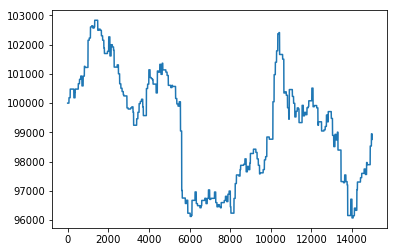

In [9]:
# plot Account value bar by bar. It changes after closing a trade.  #########JP Nieto
nModel = 0
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsRun)):
            if names[i] == modelsRun[j][1]:
                plt.plot(accountVal[j])

In [10]:
# plot Account value bar by bar. It changes after closing a trade.  #########JP Nieto
nModel = 1
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsRun)):
            if names[i] == modelsRun[j][1]:
                plt.plot(accountVal[j])

In [11]:
# plot Account value bar by bar. It changes after closing a trade.  #########JP Nieto
nModel = 2
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsRun)):
            if names[i] == modelsRun[j][1]:
                plt.plot(accountVal[j])

In [12]:
# plot Account value bar by bar. It changes after closing a trade.  #########JP Nieto
nModel = 3
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsRun)):
            if names[i] == modelsRun[j][1]:
                plt.plot(accountVal[j])

In [13]:
# plot Account value bar by bar. It changes after closing a trade.  #########JP Nieto
nModel = 4
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsRun)):
            if names[i] == modelsRun[j][1]:
                plt.plot(accountVal[j])

In [14]:
# plot Account value bar by bar. It changes after closing a trade.  #########JP Nieto
nModel = 5
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsRun)):
            if names[i] == modelsRun[j][1]:
                plt.plot(accountVal[j])

In [15]:
# plot Account value bar by bar. It changes after closing a trade.  #########JP Nieto
nModel = 6
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsRun)):
            if names[i] == modelsRun[j][1]:
                plt.plot(accountVal[j])

In [16]:
# plot Account value bar by bar. It changes after closing a trade.  #########JP Nieto
nModel = 7
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsRun)):
            if names[i] == modelsRun[j][1]:
                plt.plot(accountVal[j])

In [17]:
# plot Account value bar by bar. It changes after closing a trade.  #########JP Nieto
nModel = 8
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsRun)):
            if names[i] == modelsRun[j][1]:
                plt.plot(accountVal[j])

## Trade Filtering

In [18]:
# Parameters

# Big move quantiles
qMin = 0   
qMax = 1

# Probabilites quantiles
probQMin = 0
probQMax = 1

# Bars move in a row
nBarsConsec = 0
nBarsConsecMax = 8888888

# The range of minutes where a trade is valid after a big move
wM = 1
#

# Time 
startTime = '09:00'
endTime = '20:00'

modelsTradesFilt = []

for i in range(len(names)):
        print('--------===========--------')
        ite = 0
        nBarsUp = nBarsConsec 
        nBarsDown = nBarsConsec
        # Recal changes
        for j in range(len(modelsRun)):
            if names[i] == modelsRun[j][1]:
                print (modelsRun[j][1:])
                dTime = dateTimeIt[ite][-len(predicts[j])-T:]
                #dTime.reset_index(inplace=True, drop=True)
                chgs = changesIt[ite][-len(predicts[j])-T:]
                chgsIdx = chgs.index
                chgs = chgs.values
                chgsAbs = abs(chgs)
                #chgs.reset_index(inplace=True, drop=True)
                val1 = np.percentile(chgsAbs,qMin*100)
                val2 = np.percentile(chgsAbs,qMax*100)
                #
                probVal1 = np.percentile(tradesProbs[j],probQMin*100)
                probVal2 = np.percentile(tradesProbs[j],probQMax*100)
                #
                cUp = 0
                cDown = 0
                #
                accountEnd = accSize
                nTrades = 0
                grossProfit = 0.0
                grossLoss = 0.0
                idxLastTrade = -1
                #
                #print len(chgs)
                probFilterTrades = []
                filterTrades = []
                for m in range(len(chgs)):
                    if chgs[m] > 0:
                        cUp += 1
                        cDown = 0
                    elif chgs[m] < 0:
                        cUp = 0
                        cDown += 1
                    else: 
                        cUp = 0
                        cDown = 0
                    okToTrade = True
                    if cUp < nBarsUp and cDown < nBarsDown:
                        okToTrade = False
                    if cUp > nBarsConsecMax or cDown > nBarsConsecMax:
                        okToTrade = False
                    if chgsAbs[m] < val1 or chgsAbs[m] > val2:
                        okToTrade = False  
                    if okToTrade:
                        for n in range(len(idxTrades[j])):
                            if m+wM >= len(chgs):
                                mwM = len(chgs)-1
                            else:
                                mwM = m+wM
                            if idxTrades[j][n] > chgsIdx[m] and idxTrades[j][n] <= chgsIdx[mwM]:
                                if tradesProbs[j][n] >= probVal1 and tradesProbs[j][n] <= probVal2:
                                    if n > idxLastTrade and dTime['Time'].values[m] >= startTime and dTime['Time'].values[m] <= endTime:
                                        #print chgsIdx[m]
                                        #print barsIt[it].values[chgsIdx[m]]
                                        #print dateTimeIt[it].values[chgsIdx[m]]
                                        #print '---'
                                        #print dateTimeIt[ite][chgsIdx[m]]
                                        #print chnagesIt[ite][chgsIdx[m]]
                                        nTrades += 1
                                        if trades[j][n] > 0:
                                            grossProfit += trades[j][n]
                                        if trades[j][n] < 0:
                                            grossLoss += -trades[j][n]
                                        accountEnd += trades[j][n]
                                        idxLastTrade = n
                                        
                                        probFilterTrades.append(tradesProbs[j][n])
                                        filterTrades.append(trades[j][n])
                #
                print ('Original number of trades:', len(trades[j]) )
                print ('Filtered number of trades:', nTrades)
                print ('Account End: ', accountEnd)
                print ('Gross Profit:', grossProfit)
                print ('Gross Loss:', grossLoss)
                if nTrades > 0:
                    if grossLoss > 0:
                        print ('Profit Factor: ', grossProfit/grossLoss)
                    else:
                        print ('Profit Factor: Infinite')
                else:
                    print ('No trades')
                print ('Profit Factor unfiltered:', pFactors[j])
                #print ('Probabilities for filter in trades only: ', probFilterTrades)
                #print ('Filtered Trades:', filterTrades)
                print('......................')
                modelsTradesFilt.append([modelsRun[j][1],filterTrades])
                ite +=1 

--------===========--------
['Logistic Regression', 0, 50000]
Original number of trades: 220
Filtered number of trades: 220
Account End:  98759.23
Gross Profit: 28028.79
Gross Loss: 29269.56
Profit Factor:  0.957608860536
Profit Factor unfiltered: 0.957608860536
......................


###NOTE: Following chart shows cum sum of filtered trades one by one. Different lenght is because not plotting bar by bar as charts above

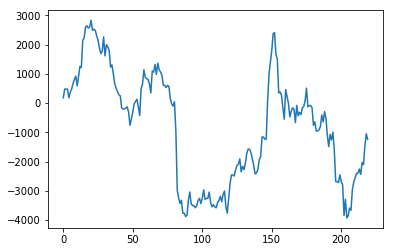

In [19]:
# plot Account value bar by bar. It changes after closing a trade.  #########JP Nieto
nModel = 0
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsTradesFilt)):
            if names[i] == modelsTradesFilt[j][0]:
                plt.plot(np.cumsum(modelsTradesFilt[j][1]))

In [20]:

nModel = 1
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsTradesFilt)):
            if names[i] == modelsTradesFilt[j][0]:
                plt.plot(np.cumsum(modelsTradesFilt[j][1]))

In [21]:

nModel = 2
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsTradesFilt)):
            if names[i] == modelsTradesFilt[j][0]:
                plt.plot(np.cumsum(modelsTradesFilt[j][1]))

In [22]:

nModel = 3
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsTradesFilt)):
            if names[i] == modelsTradesFilt[j][0]:
                plt.plot(np.cumsum(modelsTradesFilt[j][1]))

In [23]:

nModel = 4
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsTradesFilt)):
            if names[i] == modelsTradesFilt[j][0]:
                plt.plot(np.cumsum(modelsTradesFilt[j][1]))

In [24]:

nModel = 5
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsTradesFilt)):
            if names[i] == modelsTradesFilt[j][0]:
                plt.plot(np.cumsum(modelsTradesFilt[j][1]))

In [25]:

nModel = 6
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsTradesFilt)):
            if names[i] == modelsTradesFilt[j][0]:
                plt.plot(np.cumsum(modelsTradesFilt[j][1]))

In [26]:

nModel = 7
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsTradesFilt)):
            if names[i] == modelsTradesFilt[j][0]:
                plt.plot(np.cumsum(modelsTradesFilt[j][1]))

In [27]:

nModel = 8
for i in range(len(names)):
    if i == nModel:
        for j in range(len(modelsTradesFilt)):
            if names[i] == modelsTradesFilt[j][0]:
                plt.plot(np.cumsum(modelsTradesFilt[j][1]))

## Parameters Search -> Profit factor

In [28]:
PF_Active = 1  # o no 1 yes

   ### PF Parameters

In [29]:
# Parameters

#########################
modelName = 'AdaBoost' #model name

# Move quantiles
qStart = 0
qWindowStep = 0.1
qEnd = 0.9
#
# Probilities quantiles
qProbStart = 0.0
qProbWindowStep = 0.1
qProbEnd = 0.9
#
# bars move in a row (must be integers)  step always 1
nBarsStart = 0
nBarsEnd = 8

# number of valid bars after signal
wMStart = 1
wMEnd = 8

# Time 
startTime = '09:00'
endTime = '10:00'

### PF based on move

In [30]:
rslt = []   
if PF_Active == 1:
    # DO NOT MODIFY SETTINGS HERE

    # Probabilites quantiles
    probQMin = 0
    probQMax = 1

    # Bars move in a row
    nBarsConsec = 0
    nBarsConsecMax = 8

    # The range of minutes where a trade is valid after a big move
    wM = 1

    #
    ###################

    q = qStart
    while q < qEnd:
        #
        print('q:',round(q,2))
        qMin = q   
        qMax = q+qWindowStep
        for i in range(len(names)):
            #print('--------===========--------')
            ite = 0
            nBarsUp = nBarsConsec 
            nBarsDown = nBarsConsec 
            for j in range(len(modelsRun)):
                if names[i] == modelsRun[j][1]:
                    #
                    #print (modelsRun[j][1:])
                    dTime = dateTimeIt[ite][-len(predicts[j])-T:]
                    #dTime.reset_index(inplace=True, drop=True)
                    chgs = changesIt[ite][-len(predicts[j])-T:]
                    chgsIdx = chgs.index
                    chgs = chgs.values
                    chgsAbs = abs(chgs)
                    #chgs.reset_index(inplace=True, drop=True)
                    val1 = np.percentile(chgsAbs,min(qMin*100,100))
                    val2 = np.percentile(chgsAbs,min(qMax*100,100))
                    #
                    probVal1 = np.percentile(tradesProbs[j],min(probQMin*100,100))
                    probVal2 = np.percentile(tradesProbs[j],min(probQMax*100,100))
                    #
                    cUp = 0
                    cDown = 0
                    #
                    accountEnd = accSize
                    nTrades = 0
                    grossProfit = 0.0
                    grossLoss = 0.0
                    idxLastTrade = -1
                    #
                    #print len(chgs)
                    probFilterTrades = []
                    filterTrades = []
                    for m in range(len(chgs)):
                        if chgs[m] > 0:
                            cUp += 1
                            cDown = 0
                        elif chgs[m] < 0:
                            cUp = 0
                            cDown += 1
                        else: 
                            cUp = 0
                            cDown = 0
                        okToTrade = True
                        if cUp < nBarsUp and cDown < nBarsDown:
                            okToTrade = False
                        if cUp > nBarsConsecMax or cDown > nBarsConsecMax:
                            okToTrade = False
                        if chgsAbs[m] < val1 or chgsAbs[m] > val2:
                            okToTrade = False  
                        if okToTrade:
                            for n in range(len(idxTrades[j])):
                                if m+wM >= len(chgs):
                                    mwM = len(chgs)-1
                                else:
                                    mwM = m+wM
                                if idxTrades[j][n] > chgsIdx[m] and idxTrades[j][n] <= chgsIdx[mwM]:
                                    if tradesProbs[j][n] >= probVal1 and tradesProbs[j][n] <= probVal2:
                                        if n > idxLastTrade and dTime['Time'].values[m] >= startTime and dTime['Time'].values[m] <= endTime:
                                            #print chgsIdx[m]
                                            #print barsIt[it].values[chgsIdx[m]]
                                            #print dateTimeIt[it].values[chgsIdx[m]]
                                            #print '---'
                                            #print dateTimeIt[ite][chgsIdx[m]]
                                            #print chnagesIt[ite][chgsIdx[m]]
                                            nTrades += 1
                                            if trades[j][n] > 0:
                                                grossProfit += trades[j][n]
                                            if trades[j][n] < 0:
                                                grossLoss += -trades[j][n]
                                            accountEnd += trades[j][n]
                                            idxLastTrade = n
                                            probFilterTrades.append(tradesProbs[j][n])
                                            filterTrades.append(trades[j][n])
                    #
                                newPF = 0
                                if nTrades > 0 and grossLoss > 0:
                                    newPF = grossProfit/grossLoss
                                elif nTrades > 0:
                                    newPF = float("inf")
                    if modelName == names[i] and round(min(qMin*100,100),1) < 100:
                        rslt.append([modelsRun[0][1],ite,round(min(qMin*100,100),1),round(min(qMax*100,100),1), newPF, nTrades])          
                    ite += 1
        q += qWindowStep


q: 0
q: 0.1
q: 0.2
q: 0.3
q: 0.4
q: 0.5
q: 0.6
q: 0.7
q: 0.8
q: 0.9


In [31]:
rslt

[]

In [ ]:
if len(rslt) > 0:
    i2 = rslt[-1][1]
    for i in range(i2+1):
        plotRslt = []
        for j in range(len(rslt)):
            if rslt[j][1] == i:
                plotRslt.append(rslt[j][4])
        plt.plot(plotRslt)
    
   

### FP based on probability

In [ ]:
rslt = []   
if PF_Active == 1:
    # DO NOT MODIFY SETTINGS HERE

    qMin = 0   
    qMax = 1
    #

    # Bars move in a row
    nBarsConsec = 0
    nBarsConsecMax = 8

    # The range of minutes where a trade is valid after a big move
    wM = 1
    #

    ###################

    qProb = qProbStart
    while qProb < qProbEnd:
        #
        print('qProb:', round(qProb,2))
        probQMin = qProb   
        probQMax = qProb+qProbWindowStep
        for i in range(len(names)):
            #print('--------===========--------')
            ite = 0
            nBarsUp = nBarsConsec 
            nBarsDown = nBarsConsec 
            for j in range(len(modelsRun)):
                if names[i] == modelsRun[j][1]:
                    #
                    #print (modelsRun[j][1:])
                    dTime = dateTimeIt[ite][-len(predicts[j])-T:]
                    #dTime.reset_index(inplace=True, drop=True)
                    chgs = changesIt[ite][-len(predicts[j])-T:]
                    chgsIdx = chgs.index
                    chgs = chgs.values
                    chgsAbs = abs(chgs)
                    #chgs.reset_index(inplace=True, drop=True)
                    val1 = np.percentile(chgsAbs,min(qMin*100,100))
                    val2 = np.percentile(chgsAbs,min(qMax*100,100))
                    #
                    probVal1 = np.percentile(tradesProbs[j],min(probQMin*100,100))
                    probVal2 = np.percentile(tradesProbs[j],min(probQMax*100,100))
                    #
                    cUp = 0
                    cDown = 0
                    #
                    accountEnd = accSize
                    nTrades = 0
                    grossProfit = 0.0
                    grossLoss = 0.0
                    idxLastTrade = -1
                    #
                    #print len(chgs)
                    probFilterTrades = []
                    filterTrades = []
                    for m in range(len(chgs)):
                        if chgs[m] > 0:
                            cUp += 1
                            cDown = 0
                        elif chgs[m] < 0:
                            cUp = 0
                            cDown += 1
                        else: 
                            cUp = 0
                            cDown = 0
                        okToTrade = True
                        if cUp < nBarsUp and cDown < nBarsDown:
                            okToTrade = False
                        if cUp > nBarsConsecMax or cDown > nBarsConsecMax:
                            okToTrade = False
                        if chgsAbs[m] < val1 or chgsAbs[m] > val2:
                            okToTrade = False  
                        if okToTrade:
                            for n in range(len(idxTrades[j])):
                                if m+wM >= len(chgs):
                                    mwM = len(chgs)-1
                                else:
                                    mwM = m+wM
                                if idxTrades[j][n] > chgsIdx[m] and idxTrades[j][n] <= chgsIdx[mwM]:
                                    if tradesProbs[j][n] >= probVal1 and tradesProbs[j][n] <= probVal2:
                                        if n > idxLastTrade and dTime['Time'].values[m] >= startTime and dTime['Time'].values[m] <= endTime:
                                            #print chgsIdx[m]
                                            #print barsIt[it].values[chgsIdx[m]]
                                            #print dateTimeIt[it].values[chgsIdx[m]]
                                            #print '---'
                                            #print dateTimeIt[ite][chgsIdx[m]]
                                            #print chnagesIt[ite][chgsIdx[m]]
                                            nTrades += 1
                                            if trades[j][n] > 0:
                                                grossProfit += trades[j][n]
                                            if trades[j][n] < 0:
                                                grossLoss += -trades[j][n]
                                            accountEnd += trades[j][n]
                                            idxLastTrade = n
                                            probFilterTrades.append(tradesProbs[j][n])
                                            filterTrades.append(trades[j][n])
                    #
                                newPF = 0
                                if nTrades > 0 and grossLoss > 0:
                                    newPF = grossProfit/grossLoss
                                elif nTrades > 0:
                                    newPF = float("inf")
                    if modelName == names[i] and round(min(probQMin*100,100),1)< 100:
                        rslt.append([modelsRun[0][1],ite,round(min(probQMin*100,100),1),round(min(probQMax*100,100),1),newPF, nTrades])          
                    ite += 1
        qProb += qProbWindowStep


qProb: 0.0


In [ ]:
rslt

In [ ]:
if len(rslt) > 0:
    i2 = rslt[-1][1]
    for i in range(i2+1):
        plotRslt = []
        for j in range(len(rslt)):
            if rslt[j][1] == i:
                plotRslt.append(rslt[j][4])
        plt.plot(plotRslt)  

### PF based on nbarsConsec

In [ ]:
rslt = []   
if PF_Active == 1:
    # DO NOT MODIFY SETTINGS HERE

    qMin = 0   
    qMax = 1
    #

    # Probabilites quantiles
    probQMin = 0
    probQMax = 1
    
    #
    nBarsConsecMax = 8
    

    # The range of minutes where a trade is valid after a big move
    wM = 1
    #

    ###################

    nB = nBarsStart
    while nB <= nBarsEnd:
        #
        print ('nB:',nB)
        for i in range(len(names)):
            #print('--------===========--------')
            ite = 0
            nBarsUp = nB 
            nBarsDown = nB 
            for j in range(len(modelsRun)):
                if names[i] == modelsRun[j][1]:
                    #
                    #print (modelsRun[j][1:])
                    dTime = dateTimeIt[ite][-len(predicts[j])-T:]
                    #dTime.reset_index(inplace=True, drop=True)
                    chgs = changesIt[ite][-len(predicts[j])-T:]
                    chgsIdx = chgs.index
                    chgs = chgs.values
                    chgsAbs = abs(chgs)
                    #chgs.reset_index(inplace=True, drop=True)
                    val1 = np.percentile(chgsAbs,min(qMin*100,100))
                    val2 = np.percentile(chgsAbs,min(qMax*100,100))
                    #
                    probVal1 = np.percentile(tradesProbs[j],min(probQMin*100,100))
                    probVal2 = np.percentile(tradesProbs[j],min(probQMax*100,100))
                    #
                    cUp = 0
                    cDown = 0
                    #
                    accountEnd = accSize
                    nTrades = 0
                    grossProfit = 0.0
                    grossLoss = 0.0
                    idxLastTrade = -1
                    #
                    #print len(chgs)
                    probFilterTrades = []
                    filterTrades = []
                    for m in range(len(chgs)):
                        if chgs[m] > 0:
                            cUp += 1
                            cDown = 0
                        elif chgs[m] < 0:
                            cUp = 0
                            cDown += 1
                        else: 
                            cUp = 0
                            cDown = 0
                        okToTrade = True
                        if cUp < nBarsUp and cDown < nBarsDown:
                            okToTrade = False
                        if cUp > nBarsConsecMax or cDown > nBarsConsecMax:
                            okToTrade = False
                        if chgsAbs[m] < val1 or chgsAbs[m] > val2:
                            okToTrade = False  
                        if okToTrade:
                            for n in range(len(idxTrades[j])):
                                if m+wM >= len(chgs):
                                    mwM = len(chgs)-1
                                else:
                                    mwM = m+wM
                                if idxTrades[j][n] > chgsIdx[m] and idxTrades[j][n] <= chgsIdx[mwM]:
                                    if tradesProbs[j][n] >= probVal1 and tradesProbs[j][n] <= probVal2:
                                        if n > idxLastTrade and dTime['Time'].values[m] >= startTime and dTime['Time'].values[m] <= endTime:
                                            #print chgsIdx[m]
                                            #print barsIt[it].values[chgsIdx[m]]
                                            #print dateTimeIt[it].values[chgsIdx[m]]
                                            #print '---'
                                            #print dateTimeIt[ite][chgsIdx[m]]
                                            #print chnagesIt[ite][chgsIdx[m]]
                                            nTrades += 1
                                            if trades[j][n] > 0:
                                                grossProfit += trades[j][n]
                                            if trades[j][n] < 0:
                                                grossLoss += -trades[j][n]
                                            accountEnd += trades[j][n]
                                            idxLastTrade = n
                                            probFilterTrades.append(tradesProbs[j][n])
                                            filterTrades.append(trades[j][n])
                    #
                                newPF = 0
                                if nTrades > 0 and grossLoss > 0:
                                    newPF = grossProfit/grossLoss
                                elif nTrades > 0:
                                    newPF = float("inf")
                    if modelName == names[i]:
                        rslt.append([modelsRun[0][1],ite,nB,newPF, nTrades])          
                    ite += 1
        nB += 1


In [ ]:
rslt

In [ ]:
if len(rslt) > 0:
    i2 = rslt[-1][1]
    for i in range(i2+1):
        plotRslt = []
        for j in range(len(rslt)):
            if rslt[j][1] == i:
                plotRslt.append(rslt[j][3])
        plt.plot(plotRslt)  

### PF based on mW

In [ ]:
rslt = []
if PF_Active == 1:
    # DO NOT MODIFY SETTINGS HERE

    qMin = 0   
    qMax = 1
    #

    # Probabilites quantiles
    probQMin = 0
    probQMax = 1

    # Bars move in a row
    nBarsConsec = 0
    nBarsConsecMax = 8

    ###################
    wM = wMStart
    while wM <= wMEnd:
        #
        print('wM:', wM)
        for i in range(len(names)):
            #print('--------===========--------')
            ite = 0
            nBarsUp = nBarsConsec 
            nBarsDown = nBarsConsec 
            for j in range(len(modelsRun)):
                if names[i] == modelsRun[j][1]:
                    #
                    #print (modelsRun[j][1:])
                    dTime = dateTimeIt[ite][-len(predicts[j])-T:]
                    #dTime.reset_index(inplace=True, drop=True)
                    chgs = changesIt[ite][-len(predicts[j])-T:]
                    chgsIdx = chgs.index
                    chgs = chgs.values
                    chgsAbs = abs(chgs)
                    #chgs.reset_index(inplace=True, drop=True)
                    val1 = np.percentile(chgsAbs,min(qMin*100,100))
                    val2 = np.percentile(chgsAbs,min(qMax*100,100))
                    #
                    probVal1 = np.percentile(tradesProbs[j],min(probQMin*100,100))
                    probVal2 = np.percentile(tradesProbs[j],min(probQMax*100,100))
                    #
                    cUp = 0
                    cDown = 0
                    #
                    accountEnd = accSize
                    nTrades = 0
                    grossProfit = 0.0
                    grossLoss = 0.0
                    idxLastTrade = -1
                    #
                    #print len(chgs)
                    probFilterTrades = []
                    filterTrades = []
                    for m in range(len(chgs)):
                        if chgs[m] > 0:
                            cUp += 1
                            cDown = 0
                        elif chgs[m] < 0:
                            cUp = 0
                            cDown += 1
                        else: 
                            cUp = 0
                            cDown = 0
                        okToTrade = True
                        if cUp < nBarsUp and cDown < nBarsDown:
                            okToTrade = False
                        if cUp > nBarsConsecMax or cDown > nBarsConsecMax:
                            okToTrade = False
                        if chgsAbs[m] < val1 or chgsAbs[m] > val2:
                            okToTrade = False  
                        if okToTrade:
                            for n in range(len(idxTrades[j])):
                                if m+wM >= len(chgs):
                                    mwM = len(chgs)-1
                                else:
                                    mwM = m+wM
                                if idxTrades[j][n] > chgsIdx[m] and idxTrades[j][n] <= chgsIdx[mwM]:
                                    if tradesProbs[j][n] >= probVal1 and tradesProbs[j][n] <= probVal2:
                                        if n > idxLastTrade and dTime['Time'].values[m] >= startTime and dTime['Time'].values[m] <= endTime:
                                            #print chgsIdx[m]
                                            #print barsIt[it].values[chgsIdx[m]]
                                            #print dateTimeIt[it].values[chgsIdx[m]]
                                            #print '---'
                                            #print dateTimeIt[ite][chgsIdx[m]]
                                            #print chnagesIt[ite][chgsIdx[m]]
                                            nTrades += 1
                                            if trades[j][n] > 0:
                                                grossProfit += trades[j][n]
                                            if trades[j][n] < 0:
                                                grossLoss += -trades[j][n]
                                            accountEnd += trades[j][n]
                                            idxLastTrade = n
                                            probFilterTrades.append(tradesProbs[j][n])
                                            filterTrades.append(trades[j][n])
                    #
                                newPF = 0
                                if nTrades > 0 and grossLoss > 0:
                                    newPF = grossProfit/grossLoss
                                elif nTrades > 0:
                                    newPF = float("inf")
                    if modelName == names[i]:
                        rslt.append([modelsRun[0][1],ite,wM,newPF, nTrades])          
                    ite += 1
        wM += 1


In [ ]:
rslt

In [ ]:
if len(rslt) > 0:
    i2 = rslt[-1][1]
    for i in range(i2+1):
        plotRslt = []
        for j in range(len(rslt)):
            if rslt[j][1] == i:
                plotRslt.append(rslt[j][3])
        plt.plot(plotRslt)  